In [65]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import optuna
import time
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score, PredictionErrorDisplay
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

### I. Setup
Load the dataset. Identify numeric and categorical features and target. Tree-based models and SVR require similar encoding, so they are grouped together here in this notebook.

In [22]:
# Load the dataset and remove columns with missing values
ames = pd.read_csv('ames.csv', index_col=0)

# Identify numeric and categorical features, excluding 'PID' and 'SalePrice'
ames['MSSubClass'] = ames['MSSubClass'].astype(str) #Nominal variable of 'string' integers
numeric_features = ames.select_dtypes(include=['int64', 'float64']).drop(columns=['PID', 'SalePrice']).columns
categorical_features = ames.select_dtypes(include=['object']).columns
X = ames[numeric_features.tolist() + categorical_features.tolist()]
X = X.drop(columns = ['OverallQual'])

# Target variable
y = ames['SalePrice']

### II. Set up Encoding/RF Pipeline:
For pre-processing and regression with 5-fold cross-validation. Pass through numerical data, ordinally encode ordinal categorical variables, one-hot encode all other categorical variables and drop none. Instantiate RandomForest model.

In [23]:
# Define the ordinal_categories dictionary
ordinal_categories = {
    'LotShape': ['IR3', 'IR2', 'IR1', 'Reg'],
    'LandSlope': ['Sev', 'Mod', 'Gtl'],
    ('ExterQual', 'ExterCond', 'HeatingQC', 'KitchenQual'): ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    ('BsmtQual', 'BsmtCond'): ['No Bsmt', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtExposure': ['No Bsmt', 'No', 'Mn', 'Av', 'Gd'],
    ('BsmtFinType1', 'BsmtFinType2'): ['No Bsmt', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    'Electrical': ['FuseP', 'FuseF', 'FuseA', 'SBrkr'],
    'FireplaceQu': ['No Fireplace', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'GarageFinish': ['No Garage', 'Unf', 'RFn', 'Fin'],
    ('GarageQual', 'GarageCond'): ['No Garage', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'PavedDrive': ['N', 'P', 'Y'],
    'PoolQC': ['No Pool', 'Fa', 'TA', 'Gd', 'Ex'],
    'Fence': ['No Fence', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']
}


# Function to extract categories for each feature
def get_categories_dict(ordinal_categories):
    categories_dict = {}
    for key, value in ordinal_categories.items():
        if isinstance(key, tuple):
            for sub_key in key:
                categories_dict[sub_key] = value
        else:
            categories_dict[key] = value
    return categories_dict

# Extract categories for each feature
categories_dict = get_categories_dict(ordinal_categories)

# Separate feature names and their corresponding categories
feature_names = list(categories_dict.keys())
categories = [categories_dict[feature] for feature in feature_names]

# Define transformers for numerical and categorical features
numerical_features = X.select_dtypes(include=[np.number]).columns.tolist()
ordinal_categorical_features = feature_names

non_ordinal_categorical_features = [feature for feature in categorical_features if feature not in ordinal_categorical_features]

ordinal_encoder = OrdinalEncoder(categories=categories)

categorical_transformer = OneHotEncoder(drop=None, handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, non_ordinal_categorical_features),
        ('ord', ordinal_encoder, ordinal_categorical_features ),
        ('num', 'passthrough', numerical_features)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=0))
])

### III. Run RF Pipeline: 
Report the untuned RandomForest R2- basic idea of how the model performs.

In [24]:
start_time = time.time()

# Perform cross-validation and store results in a dictionary
cv_results = {}
scores = cross_val_score(pipeline, X, y)
cv_results = round(scores.mean(), 6)
# Output the mean cross-validation scores
print(cv_results)

#an untuned RandomForestRegressor (noqual) has an R2 of .8942

print(f"{time.time() - start_time} seconds")

0.89417
26.00996685028076 seconds


### IV. Tuning Hyperparameters:
Find optimal parameters for RandomForest using GridSearchCV.  
n_estimators  
max_depth  
samples_split  
samples_leaf  
max_features

In [25]:
#Helper function for reporting importances
def report_importances(mygridsearch):
    """ report_importances: returns df of importances of best model from a GridSearchCV
        mygridsearch: gridsearch object """
    best_model = mygridsearch.best_estimator_
    best_rf = best_model.named_steps['regressor']
    feature_importances = best_rf.feature_importances_
    preprocessor = best_model.named_steps['preprocessor']
    transformed_feature_names = preprocessor.get_feature_names_out()

    feature_importances_df = pd.DataFrame({
        'feature': transformed_feature_names,
        'importance': feature_importances
    })

    # Sort features by importance
    feature_importances_df = feature_importances_df.sort_values(by='importance', ascending=False)

    return feature_importances_df

In [27]:
start_time = time.time()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, non_ordinal_categorical_features),
        ('ord', ordinal_encoder, ordinal_categorical_features ),
        ('num', 'passthrough', numerical_features)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())
])

# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters for the RandomForestRegressor
    n_estimators = trial.suggest_int('regressor__n_estimators', 50, 500, step=50)
    max_depth = trial.suggest_int('regressor__max_depth', 2, 32, step=2)
    min_samples_split = trial.suggest_int('regressor__min_samples_split', 2, 20, step=2)
    min_samples_leaf = trial.suggest_int('regressor__min_samples_leaf', 1, 9, step=2)
    max_features = trial.suggest_categorical('regressor__max_features', ['sqrt', .5, 1])
    # Set the suggested hyperparameters in the pipeline
    pipeline.set_params(
        regressor__n_estimators=n_estimators,
        regressor__max_depth=max_depth,
        regressor__min_samples_split=min_samples_split,
        regressor__min_samples_leaf=min_samples_leaf,
        regressor__max_features = max_features
    )
    
    # Perform cross-validation
    scores = cross_val_score(pipeline, X, y, cv=5, scoring='r2')
    
    # Return the mean of the cross-validation scores
    return np.mean(scores)

# Create a study
study = optuna.create_study(direction='maximize')

# Optimize the study
study.optimize(objective, n_trials=100)

# Get the best hyperparameters
best_params = study.best_params
print(f"Best hyperparameters: {best_params}")

# Set the best hyperparameters in the pipeline
pipeline.set_params(**best_params)

# Fit the pipeline with the best hyperparameters
pipeline.fit(X, y)

# Get the feature importances from the best model
best_rf = pipeline.named_steps['regressor']
feature_importances = best_rf.feature_importances_

# Get the feature names after preprocessing
preprocessor = pipeline.named_steps['preprocessor']
transformed_feature_names = preprocessor.get_feature_names_out()

# Create a DataFrame for better readability
feature_importances_df = pd.DataFrame({
    'feature': transformed_feature_names,
    'importance': feature_importances
})

# Sort features by importance
feature_importances_df = feature_importances_df.sort_values(by='importance', ascending=False)
print(f"{(time.time() - start_time)/60} minutes")
# Print the feature importances
feature_importances_df

[I 2024-06-28 10:57:44,378] A new study created in memory with name: no-name-29a5a6c1-b8bd-4af2-b349-76da4c0be739
[I 2024-06-28 10:57:46,021] Trial 0 finished with value: 0.42453791716342604 and parameters: {'regressor__n_estimators': 200, 'regressor__max_depth': 12, 'regressor__min_samples_split': 18, 'regressor__min_samples_leaf': 3, 'regressor__max_features': 1}. Best is trial 0 with value: 0.42453791716342604.
[I 2024-06-28 10:57:47,012] Trial 1 finished with value: 0.8625975496903229 and parameters: {'regressor__n_estimators': 50, 'regressor__max_depth': 14, 'regressor__min_samples_split': 4, 'regressor__min_samples_leaf': 9, 'regressor__max_features': 'sqrt'}. Best is trial 1 with value: 0.8625975496903229.
[I 2024-06-28 10:57:49,715] Trial 2 finished with value: 0.4303611598205759 and parameters: {'regressor__n_estimators': 450, 'regressor__max_depth': 22, 'regressor__min_samples_split': 18, 'regressor__min_samples_leaf': 3, 'regressor__max_features': 1}. Best is trial 1 with va

[I 2024-06-28 11:07:46,311] Trial 27 finished with value: 0.8946734827225656 and parameters: {'regressor__n_estimators': 200, 'regressor__max_depth': 32, 'regressor__min_samples_split': 10, 'regressor__min_samples_leaf': 3, 'regressor__max_features': 0.5}. Best is trial 21 with value: 0.8958398163104772.
[I 2024-06-28 11:07:58,438] Trial 28 finished with value: 0.8910162019506558 and parameters: {'regressor__n_estimators': 450, 'regressor__max_depth': 30, 'regressor__min_samples_split': 8, 'regressor__min_samples_leaf': 1, 'regressor__max_features': 'sqrt'}. Best is trial 21 with value: 0.8958398163104772.
[I 2024-06-28 11:08:00,841] Trial 29 finished with value: 0.43857109804091354 and parameters: {'regressor__n_estimators': 250, 'regressor__max_depth': 16, 'regressor__min_samples_split': 6, 'regressor__min_samples_leaf': 3, 'regressor__max_features': 1}. Best is trial 21 with value: 0.8958398163104772.
[I 2024-06-28 11:08:04,930] Trial 30 finished with value: 0.8122711245854072 and p

[I 2024-06-28 11:15:40,452] Trial 54 finished with value: 0.8759862730550836 and parameters: {'regressor__n_estimators': 300, 'regressor__max_depth': 6, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 1, 'regressor__max_features': 0.5}. Best is trial 44 with value: 0.8968765129158645.
[I 2024-06-28 11:16:15,227] Trial 55 finished with value: 0.8961655504991933 and parameters: {'regressor__n_estimators': 250, 'regressor__max_depth': 16, 'regressor__min_samples_split': 4, 'regressor__min_samples_leaf': 1, 'regressor__max_features': 0.5}. Best is trial 44 with value: 0.8968765129158645.
[I 2024-06-28 11:16:50,627] Trial 56 finished with value: 0.8960410611980428 and parameters: {'regressor__n_estimators': 300, 'regressor__max_depth': 14, 'regressor__min_samples_split': 6, 'regressor__min_samples_leaf': 1, 'regressor__max_features': 0.5}. Best is trial 44 with value: 0.8968765129158645.
[I 2024-06-28 11:17:17,287] Trial 57 finished with value: 0.8933606689270027 and param

[I 2024-06-28 11:28:53,548] Trial 81 finished with value: 0.8964604936575891 and parameters: {'regressor__n_estimators': 300, 'regressor__max_depth': 22, 'regressor__min_samples_split': 6, 'regressor__min_samples_leaf': 1, 'regressor__max_features': 0.5}. Best is trial 62 with value: 0.8982091945642455.
[I 2024-06-28 11:29:42,463] Trial 82 finished with value: 0.8967176946784875 and parameters: {'regressor__n_estimators': 400, 'regressor__max_depth': 22, 'regressor__min_samples_split': 6, 'regressor__min_samples_leaf': 1, 'regressor__max_features': 0.5}. Best is trial 62 with value: 0.8982091945642455.
[I 2024-06-28 11:30:35,651] Trial 83 finished with value: 0.8971637534353558 and parameters: {'regressor__n_estimators': 400, 'regressor__max_depth': 24, 'regressor__min_samples_split': 4, 'regressor__min_samples_leaf': 1, 'regressor__max_features': 0.5}. Best is trial 62 with value: 0.8982091945642455.
[I 2024-06-28 11:31:24,766] Trial 84 finished with value: 0.8965026965520455 and para

Best hyperparameters: {'regressor__n_estimators': 300, 'regressor__max_depth': 14, 'regressor__min_samples_split': 4, 'regressor__min_samples_leaf': 1, 'regressor__max_features': 0.5}
47.201384516557056 minutes


,feature,importance
249,num__HQSF,3.661214e-01
248,num__TotalSF,1.870826e-01
196,ord__ExterQual,6.655783e-02
217,num__YearBuilt,4.941147e-02
236,num__GarageCars,3.436509e-02
...,...,...
82,cat__Condition2_RRAn,1.110982e-08
189,cat__SaleCondition_AdjLand,2.393142e-09
177,cat__MiscFeature_TenC,0.000000e+00
186,cat__SaleType_VWD,0.000000e+00


In [28]:
start_time = time.time()


preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, non_ordinal_categorical_features),
        ('ord', ordinal_encoder, ordinal_categorical_features ),
        ('num', 'passthrough', numerical_features)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())
])

# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters for the RandomForestRegressor
    n_estimators = trial.suggest_int('regressor__n_estimators', 200, 400, step=25)
    max_depth = trial.suggest_int('regressor__max_depth', 10, 18, step=1)
    min_samples_split = trial.suggest_int('regressor__min_samples_split', 2, 6, step=1)
    min_samples_leaf = trial.suggest_int('regressor__min_samples_leaf', 1, 3, step=1)
    max_features = trial.suggest_categorical('regressor__max_features', ['sqrt', .5, 1])
    # Set the suggested hyperparameters in the pipeline
    pipeline.set_params(
        regressor__n_estimators=n_estimators,
        regressor__max_depth=max_depth,
        regressor__min_samples_split=min_samples_split,
        regressor__min_samples_leaf=min_samples_leaf,
        regressor__max_features = max_features
    )
    
    # Perform cross-validation
    scores = cross_val_score(pipeline, X, y, cv=5, scoring='r2')
    
    # Return the mean of the cross-validation scores
    return np.mean(scores)

# Create a study
study = optuna.create_study(direction='maximize')

# Optimize the study
study.optimize(objective, n_trials=100)

# Get the best hyperparameters
best_params = study.best_params
print(f"Best hyperparameters: {best_params}")

# Set the best hyperparameters in the pipeline
pipeline.set_params(**best_params)

# Fit the pipeline with the best hyperparameters
pipeline.fit(X, y)

# Get the feature importances from the best model
best_rf = pipeline.named_steps['regressor']
feature_importances = best_rf.feature_importances_

# Get the feature names after preprocessing
preprocessor = pipeline.named_steps['preprocessor']
transformed_feature_names = preprocessor.get_feature_names_out()

# Create a DataFrame for better readability
feature_importances_df = pd.DataFrame({
    'feature': transformed_feature_names,
    'importance': feature_importances
})

# Sort features by importance
feature_importances_df = feature_importances_df.sort_values(by='importance', ascending=False)
print(f"{(time.time() - start_time)/60} minutes")
# Print the feature importances
feature_importances_df

[I 2024-06-28 12:08:38,984] A new study created in memory with name: no-name-cf1afae9-8092-4f46-b6ec-c16b10de8aaf
[I 2024-06-28 12:09:00,674] Trial 0 finished with value: 0.8944290529666896 and parameters: {'regressor__n_estimators': 225, 'regressor__max_depth': 12, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 2, 'regressor__max_features': 0.5}. Best is trial 0 with value: 0.8944290529666896.
[I 2024-06-28 12:09:02,031] Trial 1 finished with value: 0.4256893404861476 and parameters: {'regressor__n_estimators': 200, 'regressor__max_depth': 17, 'regressor__min_samples_split': 5, 'regressor__min_samples_leaf': 3, 'regressor__max_features': 1}. Best is trial 0 with value: 0.8944290529666896.
[I 2024-06-28 12:09:03,979] Trial 2 finished with value: 0.5061892220983537 and parameters: {'regressor__n_estimators': 300, 'regressor__max_depth': 11, 'regressor__min_samples_split': 5, 'regressor__min_samples_leaf': 2, 'regressor__max_features': 1}. Best is trial 0 with value: 0

[I 2024-06-28 12:20:44,755] Trial 27 finished with value: 0.8973377947425452 and parameters: {'regressor__n_estimators': 325, 'regressor__max_depth': 15, 'regressor__min_samples_split': 3, 'regressor__min_samples_leaf': 1, 'regressor__max_features': 0.5}. Best is trial 21 with value: 0.8976823780128818.
[I 2024-06-28 12:20:52,130] Trial 28 finished with value: 0.8947354390836917 and parameters: {'regressor__n_estimators': 275, 'regressor__max_depth': 16, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 1, 'regressor__max_features': 'sqrt'}. Best is trial 21 with value: 0.8976823780128818.
[I 2024-06-28 12:21:14,520] Trial 29 finished with value: 0.895900849636902 and parameters: {'regressor__n_estimators': 225, 'regressor__max_depth': 13, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 2, 'regressor__max_features': 0.5}. Best is trial 21 with value: 0.8976823780128818.
[I 2024-06-28 12:21:44,170] Trial 30 finished with value: 0.8976113724854196 and pa

[I 2024-06-28 12:32:31,135] Trial 54 finished with value: 0.8970655252907443 and parameters: {'regressor__n_estimators': 325, 'regressor__max_depth': 14, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 1, 'regressor__max_features': 0.5}. Best is trial 52 with value: 0.898829690772156.
[I 2024-06-28 12:33:09,809] Trial 55 finished with value: 0.8962192947474497 and parameters: {'regressor__n_estimators': 350, 'regressor__max_depth': 15, 'regressor__min_samples_split': 4, 'regressor__min_samples_leaf': 1, 'regressor__max_features': 0.5}. Best is trial 52 with value: 0.898829690772156.
[I 2024-06-28 12:33:46,292] Trial 56 finished with value: 0.896040019884342 and parameters: {'regressor__n_estimators': 300, 'regressor__max_depth': 14, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 1, 'regressor__max_features': 0.5}. Best is trial 52 with value: 0.898829690772156.
[I 2024-06-28 12:33:53,306] Trial 57 finished with value: 0.8918398903940122 and paramete

[I 2024-06-28 12:45:50,750] Trial 81 finished with value: 0.8955375729886189 and parameters: {'regressor__n_estimators': 200, 'regressor__max_depth': 17, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 1, 'regressor__max_features': 0.5}. Best is trial 52 with value: 0.898829690772156.
[I 2024-06-28 12:46:20,420] Trial 82 finished with value: 0.8976018139777404 and parameters: {'regressor__n_estimators': 225, 'regressor__max_depth': 17, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 1, 'regressor__max_features': 0.5}. Best is trial 52 with value: 0.898829690772156.
[I 2024-06-28 12:46:50,449] Trial 83 finished with value: 0.8967826906467185 and parameters: {'regressor__n_estimators': 225, 'regressor__max_depth': 18, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 1, 'regressor__max_features': 0.5}. Best is trial 52 with value: 0.898829690772156.
[I 2024-06-28 12:47:20,167] Trial 84 finished with value: 0.8964369685089654 and paramet

Best hyperparameters: {'regressor__n_estimators': 325, 'regressor__max_depth': 14, 'regressor__min_samples_split': 3, 'regressor__min_samples_leaf': 1, 'regressor__max_features': 0.5}
45.082522416114806 minutes


,feature,importance
249,num__HQSF,3.417506e-01
248,num__TotalSF,2.021787e-01
196,ord__ExterQual,6.998719e-02
217,num__YearBuilt,4.741460e-02
236,num__GarageCars,4.180579e-02
...,...,...
76,cat__Condition2_Artery,7.007072e-08
1,cat__MSSubClass_150,2.741999e-08
82,cat__Condition2_RRAn,2.257269e-08
189,cat__SaleCondition_AdjLand,1.942639e-09


### V. Tune Pipeline/Report Importances and Residuals

In [52]:
pipeline_tuned = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators = 325, max_depth = 14, min_samples_split = 3, 
                                         min_samples_leaf = 1, max_features = 0.5))
])

# Fit the pipeline with the best hyperparameters
pipeline_tuned.fit(X, y)

# Get the feature importances from the best model
best_rf = pipeline.named_steps['regressor']
feature_importances = best_rf.feature_importances_

# Get the feature names after preprocessing
preprocessor = pipeline.named_steps['preprocessor']
transformed_feature_names = preprocessor.get_feature_names_out()
transformed_feature_names = [name.split('__')[1] if '__' in name else name for name in transformed_feature_names]

# Create a DataFrame for better readability
rf_feature_importances_df = pd.DataFrame({
    'feature': transformed_feature_names,
    'importance': feature_importances
})

# Sort features by importance
rf_feature_importances_df = rf_feature_importances_df.sort_values(by='importance', ascending=False)

# Print the feature importances
rf_feature_importances_df

,feature,importance
249,HQSF,3.473459e-01
248,TotalSF,2.054859e-01
196,ExterQual,7.331959e-02
217,YearBuilt,4.536804e-02
200,BsmtQual,3.681002e-02
...,...,...
1,MSSubClass_150,8.008804e-08
81,Condition2_RRAe,7.490612e-08
82,Condition2_RRAn,6.161970e-08
106,RoofMatl_Roll,6.083849e-08


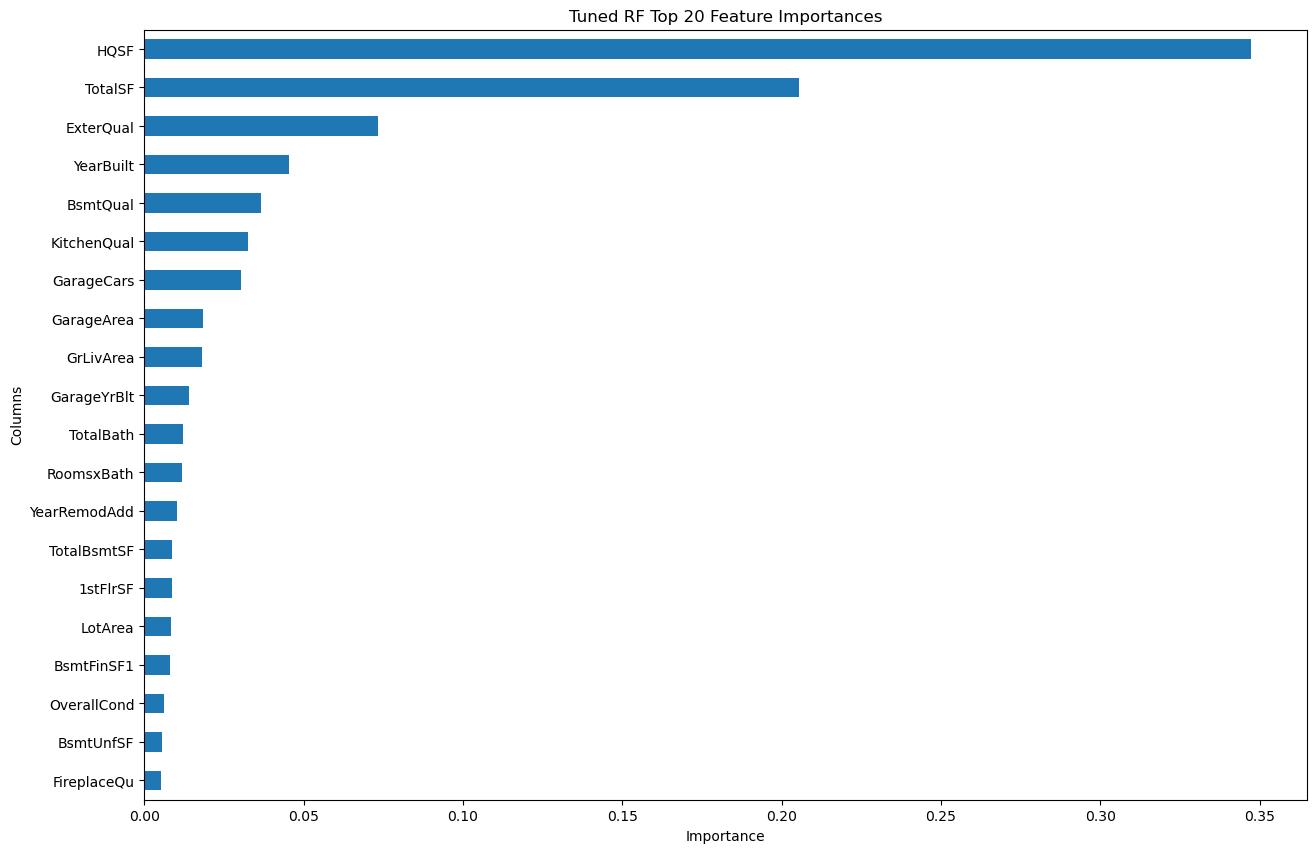

In [54]:
ax = rf_feature_importances_df.head(20).plot.barh(x = 'feature', y= 'importance', figsize = (15, 10), title = 'Tuned RF Top 20 Feature Importances')
ax.invert_yaxis()
ax.set_xlabel('Importance')
ax.set_ylabel('Columns')
ax.get_legend().remove()

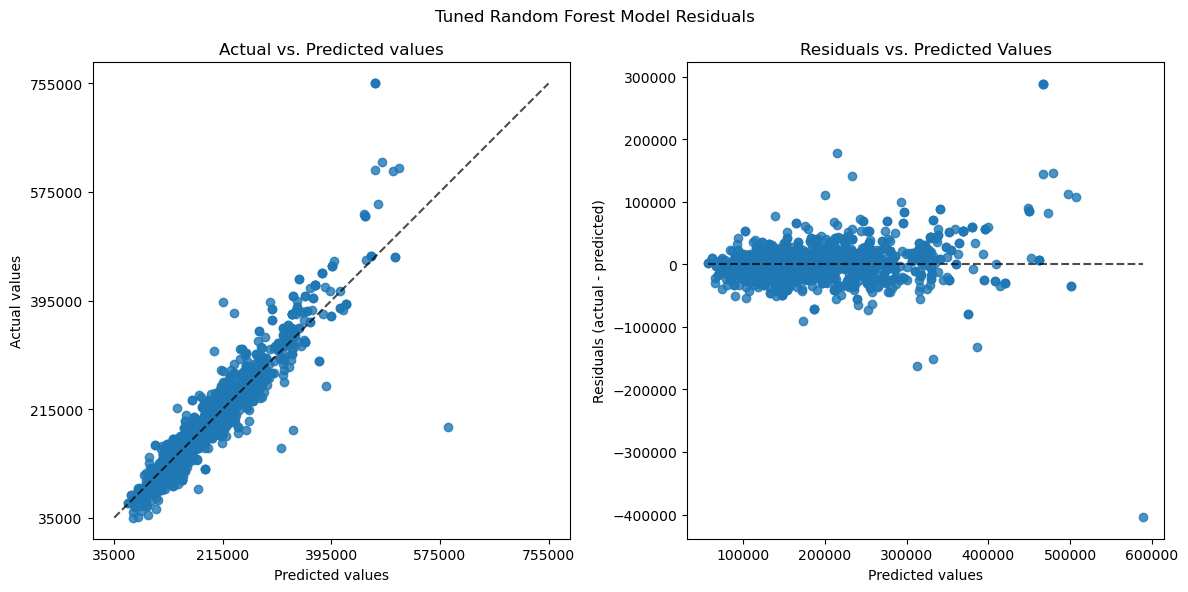

In [45]:
y_pred = cross_val_predict(pipeline_tuned, X,
                           y, cv=5)
fig, axs = plt.subplots(ncols=2, figsize=(12, 6))
PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred,
    kind="actual_vs_predicted",
    subsample=2000,
    ax=axs[0],
    random_state=0,
)
axs[0].set_title("Actual vs. Predicted values")
PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred,
    kind="residual_vs_predicted",
    subsample=2000,
    ax=axs[1],
    random_state=0,
)
axs[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Tuned Random Forest Model Residuals")
plt.tight_layout()
plt.show()

### VI. Repeat Process with GradientBoostingRegressor
Report Untuned GBoost

In [46]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, non_ordinal_categorical_features),
        ('ord', ordinal_encoder, ordinal_categorical_features ),
        ('num', 'passthrough', numerical_features) 
    ]
)

gbr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(random_state=0))
])

start_time = time.time()

# Perform cross-validation and store results in a dictionary
cv_results = {}
scores = cross_val_score(gbr_pipeline, X, y)
cv_results = round(scores.mean(), 6)
# Output the mean cross-validation scores
print(cv_results)

#an untuned GBR has an R2 of .9023

print(f"{time.time() - start_time} seconds")

0.902328
7.8722569942474365 seconds


### VII. Tune Hyperparameters

In [47]:
start_time = time.time()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, non_ordinal_categorical_features),
        ('ord', ordinal_encoder, ordinal_categorical_features ),
        ('num', 'passthrough', numerical_features) 
    ]
)

pipeline_gbr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(random_state = 0))
])

# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters for the RandomForestRegressor
    learning_rate = trial.suggest_float('regressor__learning_rate', .01, .21, step = .02)
    n_estimators = trial.suggest_int('regressor__n_estimators', 50, 500, step=50)
    max_depth = trial.suggest_int('regressor__max_depth', 2, 32, step=2)
    min_samples_split = trial.suggest_int('regressor__min_samples_split', 2, 20, step=2)
    min_samples_leaf = trial.suggest_int('regressor__min_samples_leaf', 1, 9, step=2)
    subsample = trial.suggest_float('regressor__subsample', .8, 1, step = .1)
    max_features = trial.suggest_categorical('regressor__max_features', ['sqrt', .5, 1])
   
# Set the suggested hyperparameters in the pipeline
    pipeline_gbr.set_params(
        regressor__learning_rate = learning_rate,
        regressor__n_estimators=n_estimators,
        regressor__max_depth=max_depth,
        regressor__min_samples_split=min_samples_split,
        regressor__min_samples_leaf=min_samples_leaf,
        regressor__subsample = subsample,
        regressor__max_features = max_features
    )
    
    # Perform cross-validation
    scores = cross_val_score(pipeline_gbr, X, y, cv=5, scoring='r2')
    
    # Return the mean of the cross-validation scores
    return np.mean(scores)

# Create a study
study = optuna.create_study(direction='maximize')

# Optimize the study
study.optimize(objective, n_trials=100)

# Get the best hyperparameters
best_params = study.best_params
print(f"Best hyperparameters: {best_params}")

[I 2024-06-28 14:54:14,488] A new study created in memory with name: no-name-38d6dc4e-6abc-4dd7-8f4a-35a3030d4981
[I 2024-06-28 14:54:14,995] Trial 0 finished with value: 0.5211633102961946 and parameters: {'regressor__learning_rate': 0.03, 'regressor__n_estimators': 50, 'regressor__max_depth': 12, 'regressor__min_samples_split': 14, 'regressor__min_samples_leaf': 3, 'regressor__subsample': 0.8, 'regressor__max_features': 1}. Best is trial 0 with value: 0.5211633102961946.
[I 2024-06-28 14:55:46,449] Trial 1 finished with value: 0.8968919563690386 and parameters: {'regressor__learning_rate': 0.17, 'regressor__n_estimators': 400, 'regressor__max_depth': 22, 'regressor__min_samples_split': 4, 'regressor__min_samples_leaf': 7, 'regressor__subsample': 1.0, 'regressor__max_features': 0.5}. Best is trial 1 with value: 0.8968919563690386.
[I 2024-06-28 14:55:48,908] Trial 2 finished with value: 0.8907680977384901 and parameters: {'regressor__learning_rate': 0.17, 'regressor__n_estimators': 50

[I 2024-06-28 14:59:32,260] Trial 22 finished with value: 0.9099511696899404 and parameters: {'regressor__learning_rate': 0.13, 'regressor__n_estimators': 350, 'regressor__max_depth': 6, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 7, 'regressor__subsample': 1.0, 'regressor__max_features': 0.5}. Best is trial 17 with value: 0.9109575926848207.
[I 2024-06-28 14:59:44,766] Trial 23 finished with value: 0.9116011774695071 and parameters: {'regressor__learning_rate': 0.13, 'regressor__n_estimators': 250, 'regressor__max_depth': 4, 'regressor__min_samples_split': 6, 'regressor__min_samples_leaf': 9, 'regressor__subsample': 1.0, 'regressor__max_features': 0.5}. Best is trial 23 with value: 0.9116011774695071.
[I 2024-06-28 14:59:57,183] Trial 24 finished with value: 0.9116011774695071 and parameters: {'regressor__learning_rate': 0.13, 'regressor__n_estimators': 250, 'regressor__max_depth': 4, 'regressor__min_samples_split': 6, 'regressor__min_samples_leaf': 9, 'regressor

[I 2024-06-28 15:06:42,607] Trial 45 finished with value: 0.9133970943964934 and parameters: {'regressor__learning_rate': 0.09, 'regressor__n_estimators': 450, 'regressor__max_depth': 4, 'regressor__min_samples_split': 8, 'regressor__min_samples_leaf': 9, 'regressor__subsample': 1.0, 'regressor__max_features': 0.5}. Best is trial 45 with value: 0.9133970943964934.
[I 2024-06-28 15:06:44,084] Trial 46 finished with value: 0.891149928358509 and parameters: {'regressor__learning_rate': 0.09, 'regressor__n_estimators': 450, 'regressor__max_depth': 24, 'regressor__min_samples_split': 8, 'regressor__min_samples_leaf': 9, 'regressor__subsample': 1.0, 'regressor__max_features': 1}. Best is trial 45 with value: 0.9133970943964934.
[I 2024-06-28 15:07:27,263] Trial 47 finished with value: 0.9095363664010743 and parameters: {'regressor__learning_rate': 0.09, 'regressor__n_estimators': 500, 'regressor__max_depth': 8, 'regressor__min_samples_split': 8, 'regressor__min_samples_leaf': 7, 'regressor__

[I 2024-06-28 15:18:22,047] Trial 68 finished with value: 0.8995721738621697 and parameters: {'regressor__learning_rate': 0.05, 'regressor__n_estimators': 450, 'regressor__max_depth': 14, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 3, 'regressor__subsample': 0.9, 'regressor__max_features': 0.5}. Best is trial 61 with value: 0.9138386683489406.
[I 2024-06-28 15:19:15,328] Trial 69 finished with value: 0.8997071974773391 and parameters: {'regressor__learning_rate': 0.09, 'regressor__n_estimators': 500, 'regressor__max_depth': 10, 'regressor__min_samples_split': 6, 'regressor__min_samples_leaf': 5, 'regressor__subsample': 0.9, 'regressor__max_features': 0.5}. Best is trial 61 with value: 0.9138386683489406.
[I 2024-06-28 15:19:17,135] Trial 70 finished with value: 0.887444953459851 and parameters: {'regressor__learning_rate': 0.09, 'regressor__n_estimators': 500, 'regressor__max_depth': 4, 'regressor__min_samples_split': 6, 'regressor__min_samples_leaf': 5, 'regresso

[I 2024-06-28 15:22:54,853] Trial 91 finished with value: 0.9179737614024681 and parameters: {'regressor__learning_rate': 0.03, 'regressor__n_estimators': 500, 'regressor__max_depth': 6, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 3, 'regressor__subsample': 0.8, 'regressor__max_features': 'sqrt'}. Best is trial 79 with value: 0.9179737614024681.
[I 2024-06-28 15:23:00,557] Trial 92 finished with value: 0.9103599299473917 and parameters: {'regressor__learning_rate': 0.01, 'regressor__n_estimators': 500, 'regressor__max_depth': 6, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 3, 'regressor__subsample': 0.8, 'regressor__max_features': 'sqrt'}. Best is trial 79 with value: 0.9179737614024681.
[I 2024-06-28 15:23:06,179] Trial 93 finished with value: 0.9179737614024681 and parameters: {'regressor__learning_rate': 0.03, 'regressor__n_estimators': 500, 'regressor__max_depth': 6, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 3, 'reg

Best hyperparameters: {'regressor__learning_rate': 0.03, 'regressor__n_estimators': 500, 'regressor__max_depth': 6, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 3, 'regressor__subsample': 0.8, 'regressor__max_features': 'sqrt'}


In [48]:
start_time = time.time()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, non_ordinal_categorical_features),
        ('ord', ordinal_encoder, ordinal_categorical_features ),
        ('num', 'passthrough', numerical_features)
    ]
)

pipeline_gbr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(random_state = 0))
])

# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters for the RandomForestRegressor
    learning_rate = trial.suggest_float('regressor__learning_rate', .02, .04, step = .005)
    n_estimators = trial.suggest_int('regressor__n_estimators', 400, 600, step=25)
    max_depth = trial.suggest_int('regressor__max_depth', 4, 8, step=1)
    min_samples_split = trial.suggest_int('regressor__min_samples_split', 2, 4, step=1)
    min_samples_leaf = trial.suggest_int('regressor__min_samples_leaf', 1, 4, step=1)
    subsample = trial.suggest_float('regressor__subsample', .6, 1, step = .05)
    max_features = trial.suggest_categorical('regressor__max_features', ['sqrt', .25, .5, .75, 1])
   
# Set the suggested hyperparameters in the pipeline
    pipeline_gbr.set_params(
        regressor__learning_rate = learning_rate,
        regressor__n_estimators=n_estimators,
        regressor__max_depth=max_depth,
        regressor__min_samples_split=min_samples_split,
        regressor__min_samples_leaf=min_samples_leaf,
        regressor__subsample = subsample,
        regressor__max_features = max_features
    )
    
    # Perform cross-validation
    scores = cross_val_score(pipeline_gbr, X, y, cv=5, scoring='r2')
    
    # Return the mean of the cross-validation scores
    return np.mean(scores)

# Create a study
study = optuna.create_study(direction='maximize')

# Optimize the study
study.optimize(objective, n_trials=100)

# Get the best hyperparameters
best_params = study.best_params
print(f"Best hyperparameters: {best_params}")

[I 2024-06-28 15:39:37,064] A new study created in memory with name: no-name-aa487ab0-89bb-44df-80a8-0d9d38d28e51
[I 2024-06-28 15:39:42,642] Trial 0 finished with value: 0.9152909207222507 and parameters: {'regressor__learning_rate': 0.025, 'regressor__n_estimators': 425, 'regressor__max_depth': 8, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 3, 'regressor__subsample': 0.6, 'regressor__max_features': 'sqrt'}. Best is trial 0 with value: 0.9152909207222507.
[I 2024-06-28 15:39:50,947] Trial 1 finished with value: 0.9171413646688273 and parameters: {'regressor__learning_rate': 0.02, 'regressor__n_estimators': 575, 'regressor__max_depth': 8, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 3, 'regressor__subsample': 0.85, 'regressor__max_features': 'sqrt'}. Best is trial 1 with value: 0.9171413646688273.
[I 2024-06-28 15:40:28,653] Trial 2 finished with value: 0.9091063091878441 and parameters: {'regressor__learning_rate': 0.035, 'regressor__n_estima

[I 2024-06-28 15:45:46,794] Trial 22 finished with value: 0.9167690928007021 and parameters: {'regressor__learning_rate': 0.02, 'regressor__n_estimators': 550, 'regressor__max_depth': 8, 'regressor__min_samples_split': 4, 'regressor__min_samples_leaf': 3, 'regressor__subsample': 0.8, 'regressor__max_features': 'sqrt'}. Best is trial 15 with value: 0.9172378726072395.
[I 2024-06-28 15:45:54,915] Trial 23 finished with value: 0.9139233246692532 and parameters: {'regressor__learning_rate': 0.025, 'regressor__n_estimators': 575, 'regressor__max_depth': 8, 'regressor__min_samples_split': 4, 'regressor__min_samples_leaf': 3, 'regressor__subsample': 0.8, 'regressor__max_features': 'sqrt'}. Best is trial 15 with value: 0.9172378726072395.
[I 2024-06-28 15:46:01,288] Trial 24 finished with value: 0.9151564091190639 and parameters: {'regressor__learning_rate': 0.02, 'regressor__n_estimators': 475, 'regressor__max_depth': 7, 'regressor__min_samples_split': 4, 'regressor__min_samples_leaf': 2, 're

[I 2024-06-28 15:51:51,595] Trial 45 finished with value: 0.9187516150243737 and parameters: {'regressor__learning_rate': 0.03, 'regressor__n_estimators': 600, 'regressor__max_depth': 5, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 3, 'regressor__subsample': 0.9, 'regressor__max_features': 'sqrt'}. Best is trial 44 with value: 0.9187516150243737.
[I 2024-06-28 15:51:57,624] Trial 46 finished with value: 0.916574901770278 and parameters: {'regressor__learning_rate': 0.03, 'regressor__n_estimators': 575, 'regressor__max_depth': 5, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 3, 'regressor__subsample': 0.95, 'regressor__max_features': 'sqrt'}. Best is trial 44 with value: 0.9187516150243737.
[I 2024-06-28 15:52:03,546] Trial 47 finished with value: 0.9180031348717369 and parameters: {'regressor__learning_rate': 0.03, 'regressor__n_estimators': 600, 'regressor__max_depth': 5, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 4, 'reg

[I 2024-06-28 15:55:38,879] Trial 68 finished with value: 0.9139726613437984 and parameters: {'regressor__learning_rate': 0.035, 'regressor__n_estimators': 575, 'regressor__max_depth': 4, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 4, 'regressor__subsample': 0.9, 'regressor__max_features': 0.5}. Best is trial 44 with value: 0.9187516150243737.
[I 2024-06-28 15:55:45,143] Trial 69 finished with value: 0.9168004753701204 and parameters: {'regressor__learning_rate': 0.03, 'regressor__n_estimators': 600, 'regressor__max_depth': 5, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 4, 'regressor__subsample': 0.95, 'regressor__max_features': 'sqrt'}. Best is trial 44 with value: 0.9187516150243737.
[I 2024-06-28 15:55:50,895] Trial 70 finished with value: 0.9171537003391819 and parameters: {'regressor__learning_rate': 0.03, 'regressor__n_estimators': 475, 'regressor__max_depth': 6, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 1, 'regr

[I 2024-06-28 15:59:15,006] Trial 91 finished with value: 0.9190022312151178 and parameters: {'regressor__learning_rate': 0.03, 'regressor__n_estimators': 600, 'regressor__max_depth': 6, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 4, 'regressor__subsample': 1.0, 'regressor__max_features': 'sqrt'}. Best is trial 88 with value: 0.9197402967825633.
[I 2024-06-28 15:59:22,181] Trial 92 finished with value: 0.9190022312151178 and parameters: {'regressor__learning_rate': 0.03, 'regressor__n_estimators': 600, 'regressor__max_depth': 6, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 4, 'regressor__subsample': 1.0, 'regressor__max_features': 'sqrt'}. Best is trial 88 with value: 0.9197402967825633.
[I 2024-06-28 15:59:29,356] Trial 93 finished with value: 0.9190022312151178 and parameters: {'regressor__learning_rate': 0.03, 'regressor__n_estimators': 600, 'regressor__max_depth': 6, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 4, 'reg

Best hyperparameters: {'regressor__learning_rate': 0.03, 'regressor__n_estimators': 600, 'regressor__max_depth': 6, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 4, 'regressor__subsample': 0.95, 'regressor__max_features': 'sqrt'}


### VIII. Tune Pipeline/Report Importances and Residuals

In [59]:
gbr_pipeline_tuned = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(learning_rate = 0.03, n_estimators = 600, max_depth = 6, 
                        min_samples_split = 2, min_samples_leaf = 4, subsample= 0.95, max_features = 'sqrt'))
])

# Fit the pipeline with the best hyperparameters
gbr_pipeline_tuned.fit(X, y)


# Get the feature importances from the best model
best_rf = gbr_pipeline_tuned.named_steps['regressor']
feature_importances = best_rf.feature_importances_

# Get the feature names after preprocessing
preprocessor = gbr_pipeline_tuned.named_steps['preprocessor']
transformed_feature_names = preprocessor.get_feature_names_out()
transformed_feature_names = [name.split('__')[1] if '__' in name else name for name in transformed_feature_names]

# Create a DataFrame for better readability
gbr_feature_importances_df = pd.DataFrame({
    'feature': transformed_feature_names,
    'importance': feature_importances
})

# Sort features by importance
gbr_feature_importances_df = gbr_feature_importances_df.sort_values(by='importance', ascending=False)
# Print the feature importances
gbr_feature_importances_df

,feature,importance
248,TotalSF,0.094347
249,HQSF,0.076462
224,1stFlrSF,0.060272
199,KitchenQual,0.053146
252,RoomsxBath,0.052447
...,...,...
177,MiscFeature_TenC,0.000000
175,MiscFeature_Othr,0.000000
173,MiscFeature_Gar2,0.000000
168,GarageType_Basment,0.000000


(0.0, 0.35)

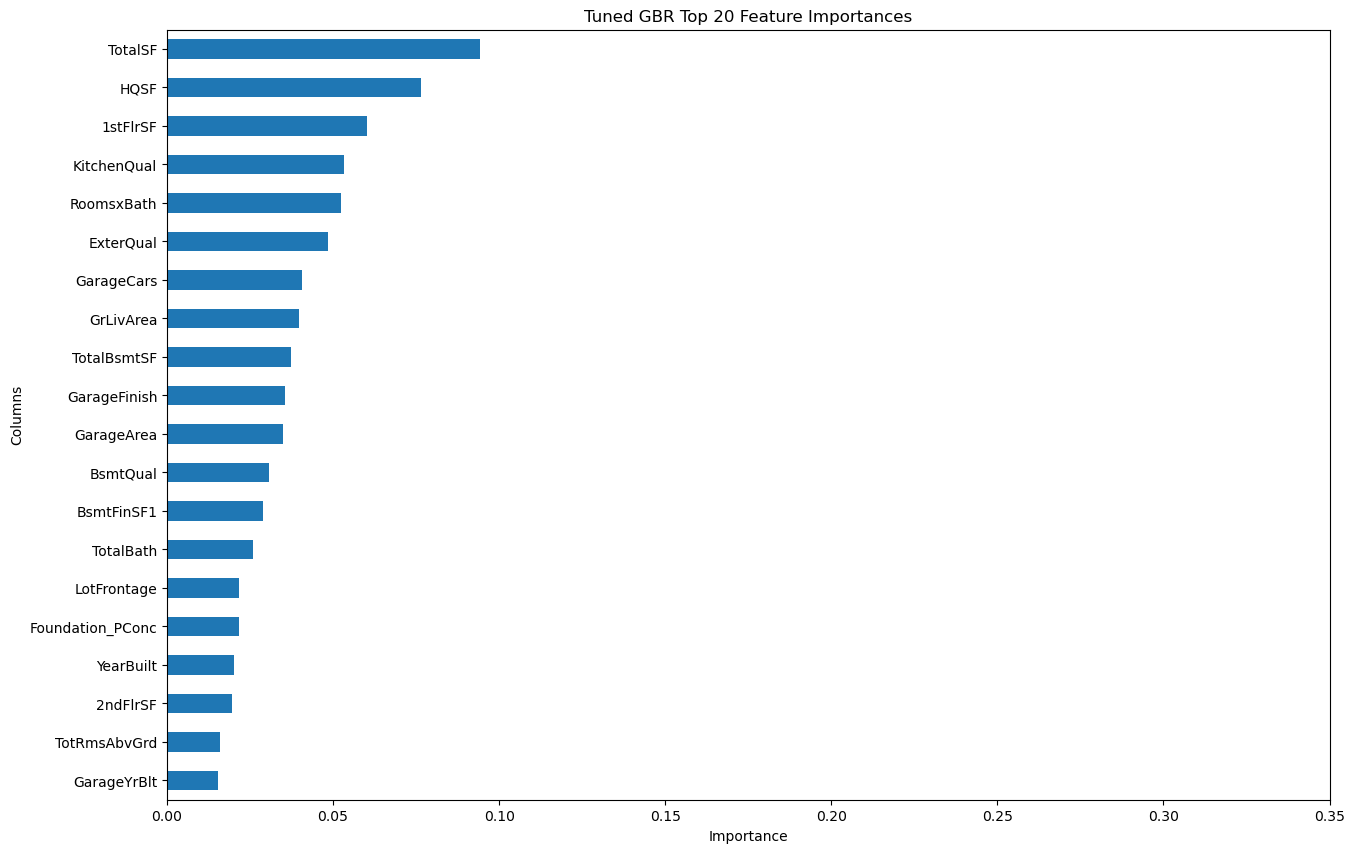

In [101]:
ax = gbr_feature_importances_df.head(20).plot.barh(x = 'feature', y= 'importance', figsize = (15, 10), title = 'Tuned GBR Top 20 Feature Importances')
ax.invert_yaxis()
ax.set_xlabel('Importance')
ax.set_ylabel('Columns')
ax.get_legend().remove()
ax.set_xlim(0, .35)

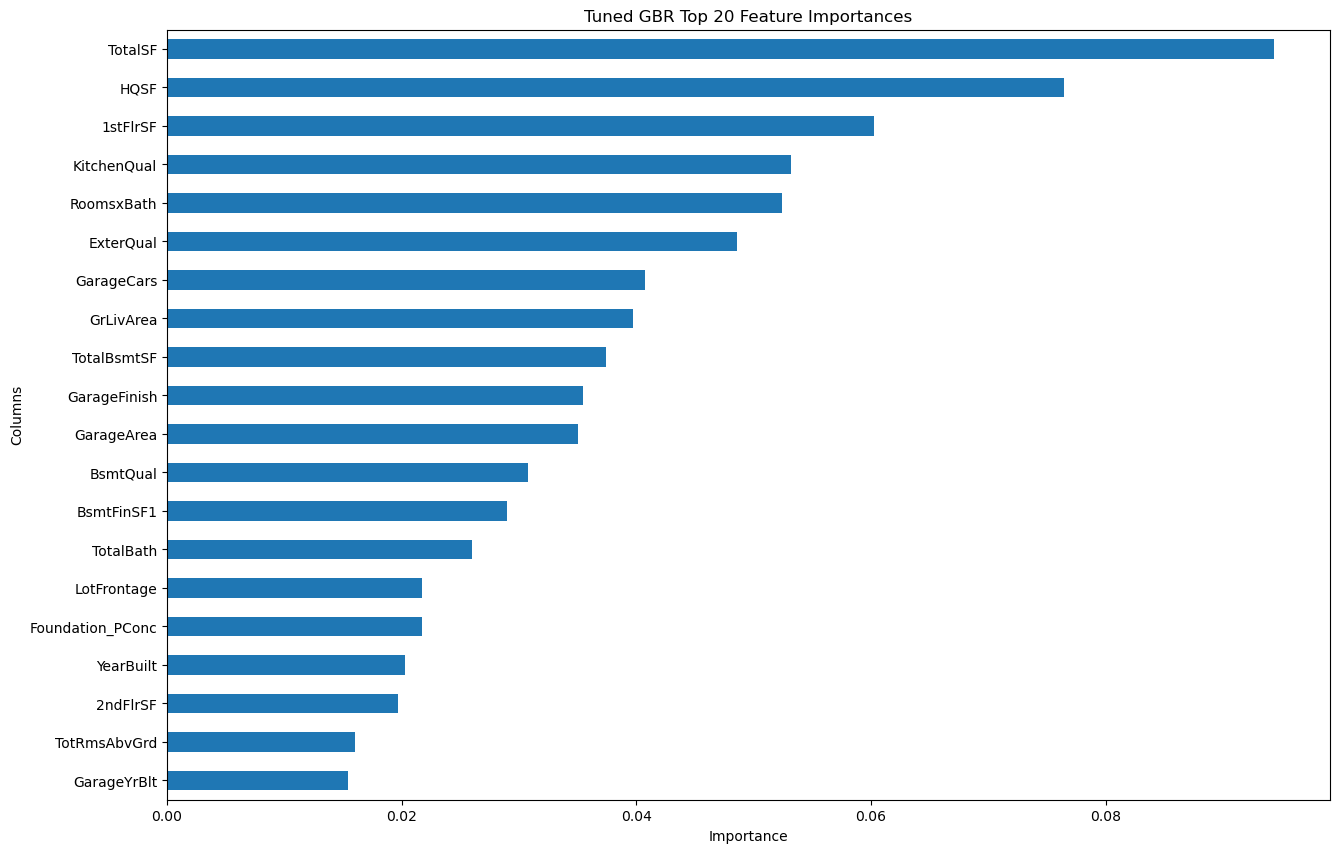

In [100]:
ax = gbr_feature_importances_df.head(20).plot.barh(x = 'feature', y= 'importance', figsize = (15, 10), title = 'Tuned GBR Top 20 Feature Importances')
ax.invert_yaxis()
ax.set_xlabel('Importance')
ax.set_ylabel('Columns')
ax.get_legend().remove()

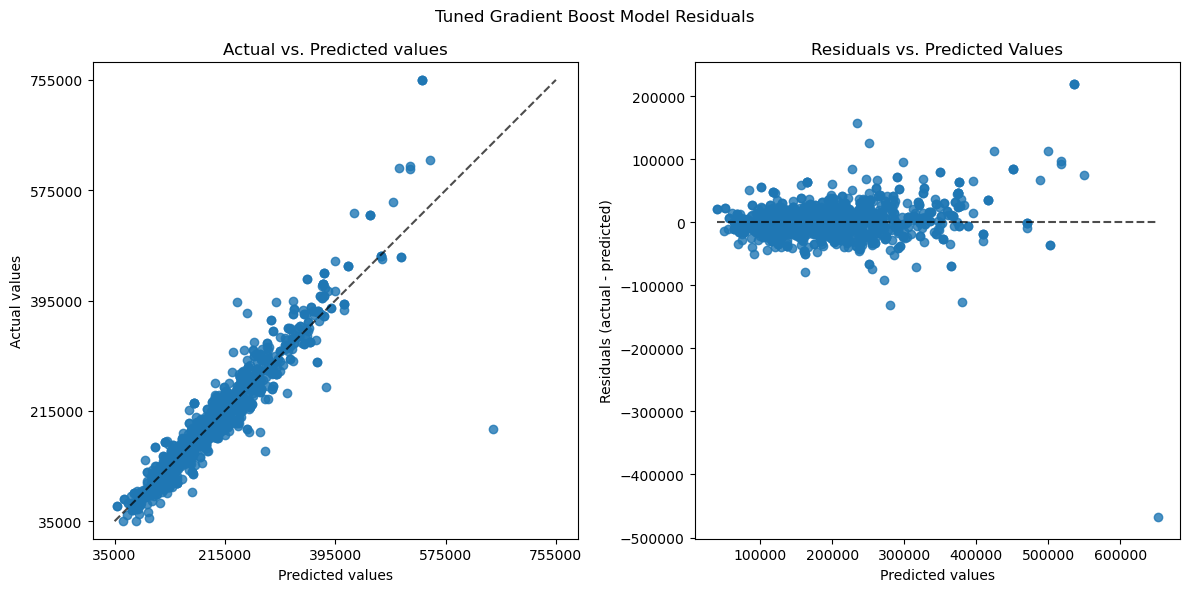

In [64]:
y_pred = cross_val_predict(gbr_pipeline_tuned, X,
                           y, cv=5)
fig, axs = plt.subplots(ncols=2, figsize=(12, 6))
PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred,
    kind="actual_vs_predicted",
    subsample=2000,
    ax=axs[0],
    random_state=0,
)
axs[0].set_title("Actual vs. Predicted values")
PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred,
    kind="residual_vs_predicted",
    subsample=2000,
    ax=axs[1],
    random_state=0,
)
axs[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Tuned Gradient Boost Model Residuals")
plt.tight_layout()
plt.show()

### IX. Repeat Process with SVR
While SVR isn't a tree-based model, it requires similar preprocessing, so to me it makes sense to include it here in this notebook.

In [66]:
ss = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, non_ordinal_categorical_features),
        ('ord', ordinal_encoder, ordinal_categorical_features),
        ('num', ss, numerical_features)
    ]
)

pipeline_SVR = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', SVR())
])


# Perform cross-validation and store results in a dictionary
cv_results = {}
scores = cross_val_score(pipeline, X, y)
cv_results = round(scores.mean(), 6)
# Output the mean cross-validation scores
print(cv_results)

#an untuned SVR has an R2 of .9054

0.897557


In [67]:
start_time = time.time()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, non_ordinal_categorical_features),
        ('ord', ordinal_encoder, ordinal_categorical_features),
        ('num', ss, numerical_features)  # scale numerical features
    ]
)

pipeline_SVR = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', SVR())
])

# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters for the SVR
    kernel = trial.suggest_categorical('regressor__kernel', ['rbf', 'linear', 'poly'])
    epsilon = trial.suggest_float('regressor__epsilon', .001, .991, step = .01)
    C = trial.suggest_int('regressor__C', 1, 100, step = 1)
    gamma = trial.suggest_categorical('regressor__gamma', ['scale', 'auto', .2, .4, .6, .8])
    
    
# Set the suggested hyperparameters in the pipeline
    pipeline_SVR.set_params(
        regressor__kernel = kernel,
        regressor__epsilon = epsilon,
        regressor__C = C,
        regressor__gamma = gamma
    )
    
    # Perform cross-validation
    scores = cross_val_score(pipeline_SVR, X, y, cv=5, scoring='r2')
    
    # Return the mean of the cross-validation scores
    return np.mean(scores)

# Create a study
study = optuna.create_study(direction='maximize')

# Optimize the study
study.optimize(objective, n_trials=100)

# Get the best hyperparameters
best_params = study.best_params
print(f"Best hyperparameters: {best_params}")
print(f"{(time.time() - start_time)/60} minutes")

[I 2024-06-29 10:28:24,336] A new study created in memory with name: no-name-1133bdda-e06f-4a36-889d-f7f9556f4307
[I 2024-06-29 10:28:28,705] Trial 0 finished with value: -0.06640391076388581 and parameters: {'regressor__kernel': 'rbf', 'regressor__epsilon': 0.251, 'regressor__C': 50, 'regressor__gamma': 0.2}. Best is trial 0 with value: -0.06640391076388581.
[I 2024-06-29 10:28:31,382] Trial 1 finished with value: 0.7275460395865482 and parameters: {'regressor__kernel': 'linear', 'regressor__epsilon': 0.871, 'regressor__C': 6, 'regressor__gamma': 0.4}. Best is trial 1 with value: 0.7275460395865482.
[I 2024-06-29 10:28:34,044] Trial 2 finished with value: 0.7763253579508343 and parameters: {'regressor__kernel': 'linear', 'regressor__epsilon': 0.751, 'regressor__C': 11, 'regressor__gamma': 'scale'}. Best is trial 2 with value: 0.7763253579508343.
[I 2024-06-29 10:28:37,864] Trial 3 finished with value: 0.12996581030049809 and parameters: {'regressor__kernel': 'rbf', 'regressor__epsilon

[I 2024-06-29 10:42:50,476] Trial 33 finished with value: 0.8762028990364383 and parameters: {'regressor__kernel': 'poly', 'regressor__epsilon': 0.521, 'regressor__C': 5, 'regressor__gamma': 0.2}. Best is trial 32 with value: 0.893096761776175.
[I 2024-06-29 10:42:53,603] Trial 34 finished with value: 0.5461578609117774 and parameters: {'regressor__kernel': 'linear', 'regressor__epsilon': 0.541, 'regressor__C': 2, 'regressor__gamma': 'scale'}. Best is trial 32 with value: 0.893096761776175.
[I 2024-06-29 10:43:42,246] Trial 35 finished with value: 0.8552421361104809 and parameters: {'regressor__kernel': 'poly', 'regressor__epsilon': 0.321, 'regressor__C': 8, 'regressor__gamma': 0.4}. Best is trial 32 with value: 0.893096761776175.
[I 2024-06-29 10:43:51,256] Trial 36 finished with value: 0.8827369520703237 and parameters: {'regressor__kernel': 'poly', 'regressor__epsilon': 0.981, 'regressor__C': 3, 'regressor__gamma': 0.2}. Best is trial 32 with value: 0.893096761776175.
[I 2024-06-29 

[I 2024-06-29 10:51:11,334] Trial 67 finished with value: 0.051031146290554566 and parameters: {'regressor__kernel': 'poly', 'regressor__epsilon': 0.791, 'regressor__C': 17, 'regressor__gamma': 'scale'}. Best is trial 66 with value: 0.8930969049823128.
[I 2024-06-29 10:51:50,581] Trial 68 finished with value: 0.8552439705638186 and parameters: {'regressor__kernel': 'poly', 'regressor__epsilon': 0.8310000000000001, 'regressor__C': 8, 'regressor__gamma': 0.4}. Best is trial 66 with value: 0.8930969049823128.
[I 2024-06-29 10:51:54,412] Trial 69 finished with value: -0.06659009408616053 and parameters: {'regressor__kernel': 'rbf', 'regressor__epsilon': 0.751, 'regressor__C': 12, 'regressor__gamma': 0.2}. Best is trial 66 with value: 0.8930969049823128.
[I 2024-06-29 10:51:57,141] Trial 70 finished with value: 0.829410937541964 and parameters: {'regressor__kernel': 'linear', 'regressor__epsilon': 0.901, 'regressor__C': 29, 'regressor__gamma': 0.2}. Best is trial 66 with value: 0.8930969049

Best hyperparameters: {'regressor__kernel': 'poly', 'regressor__epsilon': 0.9410000000000001, 'regressor__C': 1, 'regressor__gamma': 0.2}
31.748359298706056 minutes


In [70]:
start_time = time.time()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, non_ordinal_categorical_features),
        ('ord', ordinal_encoder, ordinal_categorical_features),
        ('num', ss, numerical_features)
    ]
)

pipeline_SVR = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', SVR())
])

# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters for the SVR
    kernel = trial.suggest_categorical('regressor__kernel', ['poly'])
    epsilon = trial.suggest_float('regressor__epsilon', .001, .901, step = .1)
    C = trial.suggest_int('regressor__C', 1, 99, step = 2)
    gamma = trial.suggest_categorical('regressor__gamma', ['scale', 'auto', .2, .4, .6, .8])
    
    
# Set the suggested hyperparameters in the pipeline
    pipeline_SVR.set_params(
        regressor__kernel = kernel,
        regressor__epsilon = epsilon,
        regressor__C = C,
        regressor__gamma = gamma
    )
    
    # Perform cross-validation
    scores = cross_val_score(pipeline_SVR, X, y, cv=5, scoring='r2')
    
    # Return the mean of the cross-validation scores
    return np.mean(scores)

# Create a study
study = optuna.create_study(direction='maximize')

# Optimize the study
study.optimize(objective, n_trials=100)

# Get the best hyperparameters
best_params = study.best_params
print(f"Best hyperparameters: {best_params}")
print(f"{(time.time() - start_time)/60} minutes")

[I 2024-06-29 11:14:09,182] A new study created in memory with name: no-name-5d5105b5-d055-44ee-b270-a62b9700312e
[I 2024-06-29 11:14:11,917] Trial 0 finished with value: 0.25526764491250536 and parameters: {'regressor__kernel': 'poly', 'regressor__epsilon': 0.401, 'regressor__C': 51, 'regressor__gamma': 'scale'}. Best is trial 0 with value: 0.25526764491250536.
[I 2024-06-29 11:15:07,960] Trial 1 finished with value: 0.8188197908987751 and parameters: {'regressor__kernel': 'poly', 'regressor__epsilon': 0.6010000000000001, 'regressor__C': 95, 'regressor__gamma': 0.8}. Best is trial 1 with value: 0.8188197908987751.
[I 2024-06-29 11:16:06,878] Trial 2 finished with value: 0.8267180051526312 and parameters: {'regressor__kernel': 'poly', 'regressor__epsilon': 0.7010000000000001, 'regressor__C': 19, 'regressor__gamma': 0.6}. Best is trial 2 with value: 0.8267180051526312.
[I 2024-06-29 11:16:49,302] Trial 3 finished with value: 0.8457086289465485 and parameters: {'regressor__kernel': 'poly

[I 2024-06-29 11:28:54,486] Trial 33 finished with value: 0.8653544890815722 and parameters: {'regressor__kernel': 'poly', 'regressor__epsilon': 0.801, 'regressor__C': 11, 'regressor__gamma': 0.2}. Best is trial 11 with value: 0.8930969049823128.
[I 2024-06-29 11:29:19,982] Trial 34 finished with value: 0.858147231340005 and parameters: {'regressor__kernel': 'poly', 'regressor__epsilon': 0.7010000000000001, 'regressor__C': 21, 'regressor__gamma': 0.2}. Best is trial 11 with value: 0.8930969049823128.
[I 2024-06-29 11:29:50,110] Trial 35 finished with value: 0.8574054958948265 and parameters: {'regressor__kernel': 'poly', 'regressor__epsilon': 0.801, 'regressor__C': 1, 'regressor__gamma': 0.6}. Best is trial 11 with value: 0.8930969049823128.
[I 2024-06-29 11:30:53,777] Trial 36 finished with value: 0.824453132994274 and parameters: {'regressor__kernel': 'poly', 'regressor__epsilon': 0.7010000000000001, 'regressor__C': 17, 'regressor__gamma': 0.8}. Best is trial 11 with value: 0.8930969

KeyboardInterrupt: 

In [71]:
# Define ranges of params
kernel = ['poly', 'linear']
degree = [2, 3]
epsilon = [.1, .2, .3, .4, .5]
C = [.1, .5, 1, 10, 25, 60, 100]
gamma = ['scale', 'auto', .5]

#Define parameter grid
param_grid = {
    'regressor__kernel': kernel,
    'regressor__degree': degree,
    'regressor__epsilon': epsilon,
    'regressor__C': C,
    'regressor__gamma': gamma
}

# Setup Grid Search
SVR_grid = GridSearchCV(estimator=pipeline_SVR,
                          param_grid= param_grid,
                          return_train_score=True, 
                          verbose=1) #Prints out progress
SVR_grid.fit(X, y)

SVR_grid.best_params_
SVR_grid.best_score_

Fitting 5 folds for each of 420 candidates, totalling 2100 fits
[CV] END regressor__C=0.1, regressor__degree=2, regressor__epsilon=0.1, regressor__gamma=scale, regressor__kernel=poly; total time=   0.6s
[CV] END regressor__C=0.1, regressor__degree=2, regressor__epsilon=0.1, regressor__gamma=scale, regressor__kernel=poly; total time=   0.6s
[CV] END regressor__C=0.1, regressor__degree=2, regressor__epsilon=0.1, regressor__gamma=scale, regressor__kernel=poly; total time=   0.6s
[CV] END regressor__C=0.1, regressor__degree=2, regressor__epsilon=0.1, regressor__gamma=scale, regressor__kernel=poly; total time=   0.6s
[CV] END regressor__C=0.1, regressor__degree=2, regressor__epsilon=0.1, regressor__gamma=scale, regressor__kernel=poly; total time=   0.5s
[CV] END regressor__C=0.1, regressor__degree=2, regressor__epsilon=0.1, regressor__gamma=scale, regressor__kernel=linear; total time=   0.6s
[CV] END regressor__C=0.1, regressor__degree=2, regressor__epsilon=0.1, regressor__gamma=scale, regr

[CV] END regressor__C=0.1, regressor__degree=2, regressor__epsilon=0.2, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.5s
[CV] END regressor__C=0.1, regressor__degree=2, regressor__epsilon=0.3, regressor__gamma=scale, regressor__kernel=poly; total time=   0.6s
[CV] END regressor__C=0.1, regressor__degree=2, regressor__epsilon=0.3, regressor__gamma=scale, regressor__kernel=poly; total time=   0.6s
[CV] END regressor__C=0.1, regressor__degree=2, regressor__epsilon=0.3, regressor__gamma=scale, regressor__kernel=poly; total time=   0.6s
[CV] END regressor__C=0.1, regressor__degree=2, regressor__epsilon=0.3, regressor__gamma=scale, regressor__kernel=poly; total time=   0.7s
[CV] END regressor__C=0.1, regressor__degree=2, regressor__epsilon=0.3, regressor__gamma=scale, regressor__kernel=poly; total time=   0.6s
[CV] END regressor__C=0.1, regressor__degree=2, regressor__epsilon=0.3, regressor__gamma=scale, regressor__kernel=linear; total time=   0.6s
[CV] END regressor__C=0.1

[CV] END regressor__C=0.1, regressor__degree=2, regressor__epsilon=0.4, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.6s
[CV] END regressor__C=0.1, regressor__degree=2, regressor__epsilon=0.4, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.5s
[CV] END regressor__C=0.1, regressor__degree=2, regressor__epsilon=0.5, regressor__gamma=scale, regressor__kernel=poly; total time=   0.7s
[CV] END regressor__C=0.1, regressor__degree=2, regressor__epsilon=0.5, regressor__gamma=scale, regressor__kernel=poly; total time=   0.6s
[CV] END regressor__C=0.1, regressor__degree=2, regressor__epsilon=0.5, regressor__gamma=scale, regressor__kernel=poly; total time=   0.6s
[CV] END regressor__C=0.1, regressor__degree=2, regressor__epsilon=0.5, regressor__gamma=scale, regressor__kernel=poly; total time=   0.7s
[CV] END regressor__C=0.1, regressor__degree=2, regressor__epsilon=0.5, regressor__gamma=scale, regressor__kernel=poly; total time=   0.5s
[CV] END regressor__C=0.1, 

[CV] END regressor__C=0.1, regressor__degree=3, regressor__epsilon=0.1, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.5s
[CV] END regressor__C=0.1, regressor__degree=3, regressor__epsilon=0.1, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.5s
[CV] END regressor__C=0.1, regressor__degree=3, regressor__epsilon=0.1, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.5s
[CV] END regressor__C=0.1, regressor__degree=3, regressor__epsilon=0.2, regressor__gamma=scale, regressor__kernel=poly; total time=   0.6s
[CV] END regressor__C=0.1, regressor__degree=3, regressor__epsilon=0.2, regressor__gamma=scale, regressor__kernel=poly; total time=   0.5s
[CV] END regressor__C=0.1, regressor__degree=3, regressor__epsilon=0.2, regressor__gamma=scale, regressor__kernel=poly; total time=   0.7s
[CV] END regressor__C=0.1, regressor__degree=3, regressor__epsilon=0.2, regressor__gamma=scale, regressor__kernel=poly; total time=   0.7s
[CV] END regressor__C=0.1, 

[CV] END regressor__C=0.1, regressor__degree=3, regressor__epsilon=0.3, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.6s
[CV] END regressor__C=0.1, regressor__degree=3, regressor__epsilon=0.3, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.7s
[CV] END regressor__C=0.1, regressor__degree=3, regressor__epsilon=0.3, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.7s
[CV] END regressor__C=0.1, regressor__degree=3, regressor__epsilon=0.3, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.5s
[CV] END regressor__C=0.1, regressor__degree=3, regressor__epsilon=0.4, regressor__gamma=scale, regressor__kernel=poly; total time=   0.6s
[CV] END regressor__C=0.1, regressor__degree=3, regressor__epsilon=0.4, regressor__gamma=scale, regressor__kernel=poly; total time=   0.6s
[CV] END regressor__C=0.1, regressor__degree=3, regressor__epsilon=0.4, regressor__gamma=scale, regressor__kernel=poly; total time=   0.6s
[CV] END regressor__C=0.1, 

[CV] END regressor__C=0.1, regressor__degree=3, regressor__epsilon=0.5, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.6s
[CV] END regressor__C=0.1, regressor__degree=3, regressor__epsilon=0.5, regressor__gamma=0.5, regressor__kernel=linear; total time=   1.1s
[CV] END regressor__C=0.1, regressor__degree=3, regressor__epsilon=0.5, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.7s
[CV] END regressor__C=0.1, regressor__degree=3, regressor__epsilon=0.5, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.9s
[CV] END regressor__C=0.1, regressor__degree=3, regressor__epsilon=0.5, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.6s
[CV] END regressor__C=0.5, regressor__degree=2, regressor__epsilon=0.1, regressor__gamma=scale, regressor__kernel=poly; total time=   0.7s
[CV] END regressor__C=0.5, regressor__degree=2, regressor__epsilon=0.1, regressor__gamma=scale, regressor__kernel=poly; total time=   0.6s
[CV] END regressor__C=0.5, 

[CV] END regressor__C=0.5, regressor__degree=2, regressor__epsilon=0.2, regressor__gamma=0.5, regressor__kernel=poly; total time=   0.5s
[CV] END regressor__C=0.5, regressor__degree=2, regressor__epsilon=0.2, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.5s
[CV] END regressor__C=0.5, regressor__degree=2, regressor__epsilon=0.2, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.5s
[CV] END regressor__C=0.5, regressor__degree=2, regressor__epsilon=0.2, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.5s
[CV] END regressor__C=0.5, regressor__degree=2, regressor__epsilon=0.2, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.5s
[CV] END regressor__C=0.5, regressor__degree=2, regressor__epsilon=0.2, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.5s
[CV] END regressor__C=0.5, regressor__degree=2, regressor__epsilon=0.3, regressor__gamma=scale, regressor__kernel=poly; total time=   0.6s
[CV] END regressor__C=0.5, re

[CV] END regressor__C=0.5, regressor__degree=2, regressor__epsilon=0.4, regressor__gamma=0.5, regressor__kernel=poly; total time=   0.6s
[CV] END regressor__C=0.5, regressor__degree=2, regressor__epsilon=0.4, regressor__gamma=0.5, regressor__kernel=poly; total time=   0.5s
[CV] END regressor__C=0.5, regressor__degree=2, regressor__epsilon=0.4, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.5s
[CV] END regressor__C=0.5, regressor__degree=2, regressor__epsilon=0.4, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.5s
[CV] END regressor__C=0.5, regressor__degree=2, regressor__epsilon=0.4, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.5s
[CV] END regressor__C=0.5, regressor__degree=2, regressor__epsilon=0.4, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.5s
[CV] END regressor__C=0.5, regressor__degree=2, regressor__epsilon=0.4, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.5s
[CV] END regressor__C=0.5, regr

[CV] END regressor__C=0.5, regressor__degree=3, regressor__epsilon=0.1, regressor__gamma=0.5, regressor__kernel=poly; total time=   2.7s
[CV] END regressor__C=0.5, regressor__degree=3, regressor__epsilon=0.1, regressor__gamma=0.5, regressor__kernel=poly; total time=   3.7s
[CV] END regressor__C=0.5, regressor__degree=3, regressor__epsilon=0.1, regressor__gamma=0.5, regressor__kernel=poly; total time=   4.1s
[CV] END regressor__C=0.5, regressor__degree=3, regressor__epsilon=0.1, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.6s
[CV] END regressor__C=0.5, regressor__degree=3, regressor__epsilon=0.1, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.6s
[CV] END regressor__C=0.5, regressor__degree=3, regressor__epsilon=0.1, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.5s
[CV] END regressor__C=0.5, regressor__degree=3, regressor__epsilon=0.1, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.6s
[CV] END regressor__C=0.5, regres

[CV] END regressor__C=0.5, regressor__degree=3, regressor__epsilon=0.3, regressor__gamma=0.5, regressor__kernel=poly; total time=   2.6s
[CV] END regressor__C=0.5, regressor__degree=3, regressor__epsilon=0.3, regressor__gamma=0.5, regressor__kernel=poly; total time=   2.7s
[CV] END regressor__C=0.5, regressor__degree=3, regressor__epsilon=0.3, regressor__gamma=0.5, regressor__kernel=poly; total time=   3.6s
[CV] END regressor__C=0.5, regressor__degree=3, regressor__epsilon=0.3, regressor__gamma=0.5, regressor__kernel=poly; total time=   4.0s
[CV] END regressor__C=0.5, regressor__degree=3, regressor__epsilon=0.3, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.6s
[CV] END regressor__C=0.5, regressor__degree=3, regressor__epsilon=0.3, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.6s
[CV] END regressor__C=0.5, regressor__degree=3, regressor__epsilon=0.3, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.6s
[CV] END regressor__C=0.5, regresso

[CV] END regressor__C=0.5, regressor__degree=3, regressor__epsilon=0.5, regressor__gamma=0.5, regressor__kernel=poly; total time=   3.3s
[CV] END regressor__C=0.5, regressor__degree=3, regressor__epsilon=0.5, regressor__gamma=0.5, regressor__kernel=poly; total time=   2.7s
[CV] END regressor__C=0.5, regressor__degree=3, regressor__epsilon=0.5, regressor__gamma=0.5, regressor__kernel=poly; total time=   2.6s
[CV] END regressor__C=0.5, regressor__degree=3, regressor__epsilon=0.5, regressor__gamma=0.5, regressor__kernel=poly; total time=   3.9s
[CV] END regressor__C=0.5, regressor__degree=3, regressor__epsilon=0.5, regressor__gamma=0.5, regressor__kernel=poly; total time=   3.1s
[CV] END regressor__C=0.5, regressor__degree=3, regressor__epsilon=0.5, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.6s
[CV] END regressor__C=0.5, regressor__degree=3, regressor__epsilon=0.5, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.6s
[CV] END regressor__C=0.5, regressor_

[CV] END regressor__C=1, regressor__degree=2, regressor__epsilon=0.2, regressor__gamma=0.5, regressor__kernel=poly; total time=   0.6s
[CV] END regressor__C=1, regressor__degree=2, regressor__epsilon=0.2, regressor__gamma=0.5, regressor__kernel=poly; total time=   0.6s
[CV] END regressor__C=1, regressor__degree=2, regressor__epsilon=0.2, regressor__gamma=0.5, regressor__kernel=poly; total time=   0.6s
[CV] END regressor__C=1, regressor__degree=2, regressor__epsilon=0.2, regressor__gamma=0.5, regressor__kernel=poly; total time=   0.6s
[CV] END regressor__C=1, regressor__degree=2, regressor__epsilon=0.2, regressor__gamma=0.5, regressor__kernel=poly; total time=   0.5s
[CV] END regressor__C=1, regressor__degree=2, regressor__epsilon=0.2, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.6s
[CV] END regressor__C=1, regressor__degree=2, regressor__epsilon=0.2, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.6s
[CV] END regressor__C=1, regressor__degree=2, regre

[CV] END regressor__C=1, regressor__degree=2, regressor__epsilon=0.4, regressor__gamma=0.5, regressor__kernel=poly; total time=   0.6s
[CV] END regressor__C=1, regressor__degree=2, regressor__epsilon=0.4, regressor__gamma=0.5, regressor__kernel=poly; total time=   0.6s
[CV] END regressor__C=1, regressor__degree=2, regressor__epsilon=0.4, regressor__gamma=0.5, regressor__kernel=poly; total time=   0.6s
[CV] END regressor__C=1, regressor__degree=2, regressor__epsilon=0.4, regressor__gamma=0.5, regressor__kernel=poly; total time=   0.6s
[CV] END regressor__C=1, regressor__degree=2, regressor__epsilon=0.4, regressor__gamma=0.5, regressor__kernel=poly; total time=   0.5s
[CV] END regressor__C=1, regressor__degree=2, regressor__epsilon=0.4, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.6s
[CV] END regressor__C=1, regressor__degree=2, regressor__epsilon=0.4, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.5s
[CV] END regressor__C=1, regressor__degree=2, regre

[CV] END regressor__C=1, regressor__degree=3, regressor__epsilon=0.1, regressor__gamma=0.5, regressor__kernel=poly; total time=   5.5s
[CV] END regressor__C=1, regressor__degree=3, regressor__epsilon=0.1, regressor__gamma=0.5, regressor__kernel=poly; total time=   5.2s
[CV] END regressor__C=1, regressor__degree=3, regressor__epsilon=0.1, regressor__gamma=0.5, regressor__kernel=poly; total time=   4.6s
[CV] END regressor__C=1, regressor__degree=3, regressor__epsilon=0.1, regressor__gamma=0.5, regressor__kernel=poly; total time=   4.2s
[CV] END regressor__C=1, regressor__degree=3, regressor__epsilon=0.1, regressor__gamma=0.5, regressor__kernel=poly; total time=   6.6s
[CV] END regressor__C=1, regressor__degree=3, regressor__epsilon=0.1, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.6s
[CV] END regressor__C=1, regressor__degree=3, regressor__epsilon=0.1, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.6s
[CV] END regressor__C=1, regressor__degree=3, regre

[CV] END regressor__C=1, regressor__degree=3, regressor__epsilon=0.3, regressor__gamma=0.5, regressor__kernel=poly; total time=   5.4s
[CV] END regressor__C=1, regressor__degree=3, regressor__epsilon=0.3, regressor__gamma=0.5, regressor__kernel=poly; total time=   5.1s
[CV] END regressor__C=1, regressor__degree=3, regressor__epsilon=0.3, regressor__gamma=0.5, regressor__kernel=poly; total time=   4.2s
[CV] END regressor__C=1, regressor__degree=3, regressor__epsilon=0.3, regressor__gamma=0.5, regressor__kernel=poly; total time=   4.1s
[CV] END regressor__C=1, regressor__degree=3, regressor__epsilon=0.3, regressor__gamma=0.5, regressor__kernel=poly; total time=   6.5s
[CV] END regressor__C=1, regressor__degree=3, regressor__epsilon=0.3, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.6s
[CV] END regressor__C=1, regressor__degree=3, regressor__epsilon=0.3, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.5s
[CV] END regressor__C=1, regressor__degree=3, regre

[CV] END regressor__C=1, regressor__degree=3, regressor__epsilon=0.5, regressor__gamma=0.5, regressor__kernel=poly; total time=   5.4s
[CV] END regressor__C=1, regressor__degree=3, regressor__epsilon=0.5, regressor__gamma=0.5, regressor__kernel=poly; total time=   5.6s
[CV] END regressor__C=1, regressor__degree=3, regressor__epsilon=0.5, regressor__gamma=0.5, regressor__kernel=poly; total time=   4.0s
[CV] END regressor__C=1, regressor__degree=3, regressor__epsilon=0.5, regressor__gamma=0.5, regressor__kernel=poly; total time=   4.7s
[CV] END regressor__C=1, regressor__degree=3, regressor__epsilon=0.5, regressor__gamma=0.5, regressor__kernel=poly; total time=   6.3s
[CV] END regressor__C=1, regressor__degree=3, regressor__epsilon=0.5, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.6s
[CV] END regressor__C=1, regressor__degree=3, regressor__epsilon=0.5, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.6s
[CV] END regressor__C=1, regressor__degree=3, regre

[CV] END regressor__C=10, regressor__degree=2, regressor__epsilon=0.2, regressor__gamma=0.5, regressor__kernel=poly; total time=   0.8s
[CV] END regressor__C=10, regressor__degree=2, regressor__epsilon=0.2, regressor__gamma=0.5, regressor__kernel=poly; total time=   0.8s
[CV] END regressor__C=10, regressor__degree=2, regressor__epsilon=0.2, regressor__gamma=0.5, regressor__kernel=poly; total time=   0.8s
[CV] END regressor__C=10, regressor__degree=2, regressor__epsilon=0.2, regressor__gamma=0.5, regressor__kernel=poly; total time=   0.8s
[CV] END regressor__C=10, regressor__degree=2, regressor__epsilon=0.2, regressor__gamma=0.5, regressor__kernel=poly; total time=   0.8s
[CV] END regressor__C=10, regressor__degree=2, regressor__epsilon=0.2, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.5s
[CV] END regressor__C=10, regressor__degree=2, regressor__epsilon=0.2, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.5s
[CV] END regressor__C=10, regressor__degree=

[CV] END regressor__C=10, regressor__degree=2, regressor__epsilon=0.4, regressor__gamma=0.5, regressor__kernel=poly; total time=   0.9s
[CV] END regressor__C=10, regressor__degree=2, regressor__epsilon=0.4, regressor__gamma=0.5, regressor__kernel=poly; total time=   0.8s
[CV] END regressor__C=10, regressor__degree=2, regressor__epsilon=0.4, regressor__gamma=0.5, regressor__kernel=poly; total time=   0.8s
[CV] END regressor__C=10, regressor__degree=2, regressor__epsilon=0.4, regressor__gamma=0.5, regressor__kernel=poly; total time=   0.9s
[CV] END regressor__C=10, regressor__degree=2, regressor__epsilon=0.4, regressor__gamma=0.5, regressor__kernel=poly; total time=   0.9s
[CV] END regressor__C=10, regressor__degree=2, regressor__epsilon=0.4, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.6s
[CV] END regressor__C=10, regressor__degree=2, regressor__epsilon=0.4, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.6s
[CV] END regressor__C=10, regressor__degree=

[CV] END regressor__C=10, regressor__degree=3, regressor__epsilon=0.1, regressor__gamma=0.5, regressor__kernel=poly; total time=  11.8s
[CV] END regressor__C=10, regressor__degree=3, regressor__epsilon=0.1, regressor__gamma=0.5, regressor__kernel=poly; total time=   8.9s
[CV] END regressor__C=10, regressor__degree=3, regressor__epsilon=0.1, regressor__gamma=0.5, regressor__kernel=poly; total time=  15.1s
[CV] END regressor__C=10, regressor__degree=3, regressor__epsilon=0.1, regressor__gamma=0.5, regressor__kernel=poly; total time=   8.8s
[CV] END regressor__C=10, regressor__degree=3, regressor__epsilon=0.1, regressor__gamma=0.5, regressor__kernel=poly; total time=  15.4s
[CV] END regressor__C=10, regressor__degree=3, regressor__epsilon=0.1, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.6s
[CV] END regressor__C=10, regressor__degree=3, regressor__epsilon=0.1, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.5s
[CV] END regressor__C=10, regressor__degree=

[CV] END regressor__C=10, regressor__degree=3, regressor__epsilon=0.3, regressor__gamma=0.5, regressor__kernel=poly; total time=  11.6s
[CV] END regressor__C=10, regressor__degree=3, regressor__epsilon=0.3, regressor__gamma=0.5, regressor__kernel=poly; total time=   8.7s
[CV] END regressor__C=10, regressor__degree=3, regressor__epsilon=0.3, regressor__gamma=0.5, regressor__kernel=poly; total time=  14.8s
[CV] END regressor__C=10, regressor__degree=3, regressor__epsilon=0.3, regressor__gamma=0.5, regressor__kernel=poly; total time=   8.7s
[CV] END regressor__C=10, regressor__degree=3, regressor__epsilon=0.3, regressor__gamma=0.5, regressor__kernel=poly; total time=   8.9s
[CV] END regressor__C=10, regressor__degree=3, regressor__epsilon=0.3, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.6s
[CV] END regressor__C=10, regressor__degree=3, regressor__epsilon=0.3, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.6s
[CV] END regressor__C=10, regressor__degree=

[CV] END regressor__C=10, regressor__degree=3, regressor__epsilon=0.5, regressor__gamma=0.5, regressor__kernel=poly; total time=  11.4s
[CV] END regressor__C=10, regressor__degree=3, regressor__epsilon=0.5, regressor__gamma=0.5, regressor__kernel=poly; total time=   8.5s
[CV] END regressor__C=10, regressor__degree=3, regressor__epsilon=0.5, regressor__gamma=0.5, regressor__kernel=poly; total time=  14.6s
[CV] END regressor__C=10, regressor__degree=3, regressor__epsilon=0.5, regressor__gamma=0.5, regressor__kernel=poly; total time=   8.5s
[CV] END regressor__C=10, regressor__degree=3, regressor__epsilon=0.5, regressor__gamma=0.5, regressor__kernel=poly; total time=   8.9s
[CV] END regressor__C=10, regressor__degree=3, regressor__epsilon=0.5, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.6s
[CV] END regressor__C=10, regressor__degree=3, regressor__epsilon=0.5, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.6s
[CV] END regressor__C=10, regressor__degree=

[CV] END regressor__C=25, regressor__degree=2, regressor__epsilon=0.2, regressor__gamma=0.5, regressor__kernel=poly; total time=   1.6s
[CV] END regressor__C=25, regressor__degree=2, regressor__epsilon=0.2, regressor__gamma=0.5, regressor__kernel=poly; total time=   1.5s
[CV] END regressor__C=25, regressor__degree=2, regressor__epsilon=0.2, regressor__gamma=0.5, regressor__kernel=poly; total time=   1.3s
[CV] END regressor__C=25, regressor__degree=2, regressor__epsilon=0.2, regressor__gamma=0.5, regressor__kernel=poly; total time=   1.5s
[CV] END regressor__C=25, regressor__degree=2, regressor__epsilon=0.2, regressor__gamma=0.5, regressor__kernel=poly; total time=   1.9s
[CV] END regressor__C=25, regressor__degree=2, regressor__epsilon=0.2, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.6s
[CV] END regressor__C=25, regressor__degree=2, regressor__epsilon=0.2, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.5s
[CV] END regressor__C=25, regressor__degree=

[CV] END regressor__C=25, regressor__degree=2, regressor__epsilon=0.4, regressor__gamma=0.5, regressor__kernel=poly; total time=   1.6s
[CV] END regressor__C=25, regressor__degree=2, regressor__epsilon=0.4, regressor__gamma=0.5, regressor__kernel=poly; total time=   1.4s
[CV] END regressor__C=25, regressor__degree=2, regressor__epsilon=0.4, regressor__gamma=0.5, regressor__kernel=poly; total time=   1.3s
[CV] END regressor__C=25, regressor__degree=2, regressor__epsilon=0.4, regressor__gamma=0.5, regressor__kernel=poly; total time=   1.4s
[CV] END regressor__C=25, regressor__degree=2, regressor__epsilon=0.4, regressor__gamma=0.5, regressor__kernel=poly; total time=   1.4s
[CV] END regressor__C=25, regressor__degree=2, regressor__epsilon=0.4, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.6s
[CV] END regressor__C=25, regressor__degree=2, regressor__epsilon=0.4, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.5s
[CV] END regressor__C=25, regressor__degree=

[CV] END regressor__C=25, regressor__degree=3, regressor__epsilon=0.1, regressor__gamma=0.5, regressor__kernel=poly; total time=  12.6s
[CV] END regressor__C=25, regressor__degree=3, regressor__epsilon=0.1, regressor__gamma=0.5, regressor__kernel=poly; total time=   9.4s
[CV] END regressor__C=25, regressor__degree=3, regressor__epsilon=0.1, regressor__gamma=0.5, regressor__kernel=poly; total time=   9.8s
[CV] END regressor__C=25, regressor__degree=3, regressor__epsilon=0.1, regressor__gamma=0.5, regressor__kernel=poly; total time=   9.4s
[CV] END regressor__C=25, regressor__degree=3, regressor__epsilon=0.1, regressor__gamma=0.5, regressor__kernel=poly; total time=  16.0s
[CV] END regressor__C=25, regressor__degree=3, regressor__epsilon=0.1, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.6s
[CV] END regressor__C=25, regressor__degree=3, regressor__epsilon=0.1, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.6s
[CV] END regressor__C=25, regressor__degree=

[CV] END regressor__C=25, regressor__degree=3, regressor__epsilon=0.3, regressor__gamma=0.5, regressor__kernel=poly; total time=  12.3s
[CV] END regressor__C=25, regressor__degree=3, regressor__epsilon=0.3, regressor__gamma=0.5, regressor__kernel=poly; total time=   8.9s
[CV] END regressor__C=25, regressor__degree=3, regressor__epsilon=0.3, regressor__gamma=0.5, regressor__kernel=poly; total time=   9.9s
[CV] END regressor__C=25, regressor__degree=3, regressor__epsilon=0.3, regressor__gamma=0.5, regressor__kernel=poly; total time=   9.2s
[CV] END regressor__C=25, regressor__degree=3, regressor__epsilon=0.3, regressor__gamma=0.5, regressor__kernel=poly; total time=   9.3s
[CV] END regressor__C=25, regressor__degree=3, regressor__epsilon=0.3, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.5s
[CV] END regressor__C=25, regressor__degree=3, regressor__epsilon=0.3, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.5s
[CV] END regressor__C=25, regressor__degree=

[CV] END regressor__C=25, regressor__degree=3, regressor__epsilon=0.5, regressor__gamma=0.5, regressor__kernel=poly; total time=  12.2s
[CV] END regressor__C=25, regressor__degree=3, regressor__epsilon=0.5, regressor__gamma=0.5, regressor__kernel=poly; total time=   8.8s
[CV] END regressor__C=25, regressor__degree=3, regressor__epsilon=0.5, regressor__gamma=0.5, regressor__kernel=poly; total time=   9.5s
[CV] END regressor__C=25, regressor__degree=3, regressor__epsilon=0.5, regressor__gamma=0.5, regressor__kernel=poly; total time=   9.1s
[CV] END regressor__C=25, regressor__degree=3, regressor__epsilon=0.5, regressor__gamma=0.5, regressor__kernel=poly; total time=  15.7s
[CV] END regressor__C=25, regressor__degree=3, regressor__epsilon=0.5, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.6s
[CV] END regressor__C=25, regressor__degree=3, regressor__epsilon=0.5, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.5s
[CV] END regressor__C=25, regressor__degree=

[CV] END regressor__C=60, regressor__degree=2, regressor__epsilon=0.2, regressor__gamma=0.5, regressor__kernel=poly; total time=   5.1s
[CV] END regressor__C=60, regressor__degree=2, regressor__epsilon=0.2, regressor__gamma=0.5, regressor__kernel=poly; total time=   3.7s
[CV] END regressor__C=60, regressor__degree=2, regressor__epsilon=0.2, regressor__gamma=0.5, regressor__kernel=poly; total time=   2.9s
[CV] END regressor__C=60, regressor__degree=2, regressor__epsilon=0.2, regressor__gamma=0.5, regressor__kernel=poly; total time=   4.4s
[CV] END regressor__C=60, regressor__degree=2, regressor__epsilon=0.2, regressor__gamma=0.5, regressor__kernel=poly; total time=   3.2s
[CV] END regressor__C=60, regressor__degree=2, regressor__epsilon=0.2, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.6s
[CV] END regressor__C=60, regressor__degree=2, regressor__epsilon=0.2, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.5s
[CV] END regressor__C=60, regressor__degree=

[CV] END regressor__C=60, regressor__degree=2, regressor__epsilon=0.4, regressor__gamma=0.5, regressor__kernel=poly; total time=   3.3s
[CV] END regressor__C=60, regressor__degree=2, regressor__epsilon=0.4, regressor__gamma=0.5, regressor__kernel=poly; total time=   3.8s
[CV] END regressor__C=60, regressor__degree=2, regressor__epsilon=0.4, regressor__gamma=0.5, regressor__kernel=poly; total time=   3.4s
[CV] END regressor__C=60, regressor__degree=2, regressor__epsilon=0.4, regressor__gamma=0.5, regressor__kernel=poly; total time=   4.0s
[CV] END regressor__C=60, regressor__degree=2, regressor__epsilon=0.4, regressor__gamma=0.5, regressor__kernel=poly; total time=   3.1s
[CV] END regressor__C=60, regressor__degree=2, regressor__epsilon=0.4, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.6s
[CV] END regressor__C=60, regressor__degree=2, regressor__epsilon=0.4, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.5s
[CV] END regressor__C=60, regressor__degree=

[CV] END regressor__C=60, regressor__degree=3, regressor__epsilon=0.1, regressor__gamma=0.5, regressor__kernel=poly; total time=  12.7s
[CV] END regressor__C=60, regressor__degree=3, regressor__epsilon=0.1, regressor__gamma=0.5, regressor__kernel=poly; total time=   9.1s
[CV] END regressor__C=60, regressor__degree=3, regressor__epsilon=0.1, regressor__gamma=0.5, regressor__kernel=poly; total time=  10.0s
[CV] END regressor__C=60, regressor__degree=3, regressor__epsilon=0.1, regressor__gamma=0.5, regressor__kernel=poly; total time=   9.8s
[CV] END regressor__C=60, regressor__degree=3, regressor__epsilon=0.1, regressor__gamma=0.5, regressor__kernel=poly; total time=  17.3s
[CV] END regressor__C=60, regressor__degree=3, regressor__epsilon=0.1, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.5s
[CV] END regressor__C=60, regressor__degree=3, regressor__epsilon=0.1, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.5s
[CV] END regressor__C=60, regressor__degree=

[CV] END regressor__C=60, regressor__degree=3, regressor__epsilon=0.3, regressor__gamma=0.5, regressor__kernel=poly; total time=  12.4s
[CV] END regressor__C=60, regressor__degree=3, regressor__epsilon=0.3, regressor__gamma=0.5, regressor__kernel=poly; total time=   9.1s
[CV] END regressor__C=60, regressor__degree=3, regressor__epsilon=0.3, regressor__gamma=0.5, regressor__kernel=poly; total time=   9.7s
[CV] END regressor__C=60, regressor__degree=3, regressor__epsilon=0.3, regressor__gamma=0.5, regressor__kernel=poly; total time=   9.5s
[CV] END regressor__C=60, regressor__degree=3, regressor__epsilon=0.3, regressor__gamma=0.5, regressor__kernel=poly; total time=  15.7s
[CV] END regressor__C=60, regressor__degree=3, regressor__epsilon=0.3, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.6s
[CV] END regressor__C=60, regressor__degree=3, regressor__epsilon=0.3, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.5s
[CV] END regressor__C=60, regressor__degree=

[CV] END regressor__C=60, regressor__degree=3, regressor__epsilon=0.5, regressor__gamma=0.5, regressor__kernel=poly; total time=  12.2s
[CV] END regressor__C=60, regressor__degree=3, regressor__epsilon=0.5, regressor__gamma=0.5, regressor__kernel=poly; total time=   8.9s
[CV] END regressor__C=60, regressor__degree=3, regressor__epsilon=0.5, regressor__gamma=0.5, regressor__kernel=poly; total time=   9.8s
[CV] END regressor__C=60, regressor__degree=3, regressor__epsilon=0.5, regressor__gamma=0.5, regressor__kernel=poly; total time=  16.4s
[CV] END regressor__C=60, regressor__degree=3, regressor__epsilon=0.5, regressor__gamma=0.5, regressor__kernel=poly; total time=  15.4s
[CV] END regressor__C=60, regressor__degree=3, regressor__epsilon=0.5, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.5s
[CV] END regressor__C=60, regressor__degree=3, regressor__epsilon=0.5, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.5s
[CV] END regressor__C=60, regressor__degree=

[CV] END regressor__C=100, regressor__degree=2, regressor__epsilon=0.2, regressor__gamma=0.5, regressor__kernel=poly; total time=   6.2s
[CV] END regressor__C=100, regressor__degree=2, regressor__epsilon=0.2, regressor__gamma=0.5, regressor__kernel=poly; total time=   4.7s
[CV] END regressor__C=100, regressor__degree=2, regressor__epsilon=0.2, regressor__gamma=0.5, regressor__kernel=poly; total time=   7.4s
[CV] END regressor__C=100, regressor__degree=2, regressor__epsilon=0.2, regressor__gamma=0.5, regressor__kernel=poly; total time=   4.7s
[CV] END regressor__C=100, regressor__degree=2, regressor__epsilon=0.2, regressor__gamma=0.5, regressor__kernel=poly; total time=   6.3s
[CV] END regressor__C=100, regressor__degree=2, regressor__epsilon=0.2, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.5s
[CV] END regressor__C=100, regressor__degree=2, regressor__epsilon=0.2, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.5s
[CV] END regressor__C=100, regressor_

[CV] END regressor__C=100, regressor__degree=2, regressor__epsilon=0.4, regressor__gamma=auto, regressor__kernel=linear; total time=   0.5s
[CV] END regressor__C=100, regressor__degree=2, regressor__epsilon=0.4, regressor__gamma=0.5, regressor__kernel=poly; total time=   6.7s
[CV] END regressor__C=100, regressor__degree=2, regressor__epsilon=0.4, regressor__gamma=0.5, regressor__kernel=poly; total time=   7.2s
[CV] END regressor__C=100, regressor__degree=2, regressor__epsilon=0.4, regressor__gamma=0.5, regressor__kernel=poly; total time=   5.4s
[CV] END regressor__C=100, regressor__degree=2, regressor__epsilon=0.4, regressor__gamma=0.5, regressor__kernel=poly; total time=   4.5s
[CV] END regressor__C=100, regressor__degree=2, regressor__epsilon=0.4, regressor__gamma=0.5, regressor__kernel=poly; total time=   4.7s
[CV] END regressor__C=100, regressor__degree=2, regressor__epsilon=0.4, regressor__gamma=0.5, regressor__kernel=linear; total time=   0.5s
[CV] END regressor__C=100, regressor

[CV] END regressor__C=100, regressor__degree=3, regressor__epsilon=0.1, regressor__gamma=auto, regressor__kernel=linear; total time=   0.5s
[CV] END regressor__C=100, regressor__degree=3, regressor__epsilon=0.1, regressor__gamma=auto, regressor__kernel=linear; total time=   0.5s
[CV] END regressor__C=100, regressor__degree=3, regressor__epsilon=0.1, regressor__gamma=0.5, regressor__kernel=poly; total time=  14.6s
[CV] END regressor__C=100, regressor__degree=3, regressor__epsilon=0.1, regressor__gamma=0.5, regressor__kernel=poly; total time=   9.6s
[CV] END regressor__C=100, regressor__degree=3, regressor__epsilon=0.1, regressor__gamma=0.5, regressor__kernel=poly; total time=   9.8s
[CV] END regressor__C=100, regressor__degree=3, regressor__epsilon=0.1, regressor__gamma=0.5, regressor__kernel=poly; total time=   9.8s
[CV] END regressor__C=100, regressor__degree=3, regressor__epsilon=0.1, regressor__gamma=0.5, regressor__kernel=poly; total time=  15.7s
[CV] END regressor__C=100, regresso

[CV] END regressor__C=100, regressor__degree=3, regressor__epsilon=0.3, regressor__gamma=auto, regressor__kernel=linear; total time=   0.5s
[CV] END regressor__C=100, regressor__degree=3, regressor__epsilon=0.3, regressor__gamma=auto, regressor__kernel=linear; total time=   0.5s
[CV] END regressor__C=100, regressor__degree=3, regressor__epsilon=0.3, regressor__gamma=auto, regressor__kernel=linear; total time=   0.5s
[CV] END regressor__C=100, regressor__degree=3, regressor__epsilon=0.3, regressor__gamma=0.5, regressor__kernel=poly; total time=  14.6s
[CV] END regressor__C=100, regressor__degree=3, regressor__epsilon=0.3, regressor__gamma=0.5, regressor__kernel=poly; total time=  10.8s
[CV] END regressor__C=100, regressor__degree=3, regressor__epsilon=0.3, regressor__gamma=0.5, regressor__kernel=poly; total time=  10.7s
[CV] END regressor__C=100, regressor__degree=3, regressor__epsilon=0.3, regressor__gamma=0.5, regressor__kernel=poly; total time=  10.7s
[CV] END regressor__C=100, regre

[CV] END regressor__C=100, regressor__degree=3, regressor__epsilon=0.5, regressor__gamma=auto, regressor__kernel=linear; total time=   0.6s
[CV] END regressor__C=100, regressor__degree=3, regressor__epsilon=0.5, regressor__gamma=auto, regressor__kernel=linear; total time=   0.6s
[CV] END regressor__C=100, regressor__degree=3, regressor__epsilon=0.5, regressor__gamma=auto, regressor__kernel=linear; total time=   0.6s
[CV] END regressor__C=100, regressor__degree=3, regressor__epsilon=0.5, regressor__gamma=auto, regressor__kernel=linear; total time=   0.5s
[CV] END regressor__C=100, regressor__degree=3, regressor__epsilon=0.5, regressor__gamma=0.5, regressor__kernel=poly; total time=  14.1s
[CV] END regressor__C=100, regressor__degree=3, regressor__epsilon=0.5, regressor__gamma=0.5, regressor__kernel=poly; total time=   9.5s
[CV] END regressor__C=100, regressor__degree=3, regressor__epsilon=0.5, regressor__gamma=0.5, regressor__kernel=poly; total time=   9.5s
[CV] END regressor__C=100, re

{'regressor__C': 10,
 'regressor__degree': 2,
 'regressor__epsilon': 0.1,
 'regressor__gamma': 0.5,
 'regressor__kernel': 'poly'}

In [72]:
SVR_grid.best_score_

0.9097807825560513

In [75]:
# Define ranges of params
kernel = ['poly']
degree = [2]
epsilon = [.001, .01, .1, .3, .5, .7, .9]
C = [6, 8, 10, 12, 14]
gamma = ['scale', 'auto', .2, .5, .8]

#Define parameter grid
param_grid = {
    'regressor__kernel': kernel,
    'regressor__degree': degree,
    'regressor__epsilon': epsilon,
    'regressor__C': C,
    'regressor__gamma': gamma
}

# Setup Grid Search
SVR_grid = GridSearchCV(estimator=pipeline_SVR,
                          param_grid= param_grid,
                          return_train_score=True, 
                          verbose=1)
SVR_grid.fit(X, y)

print(SVR_grid.best_params_)
print(SVR_grid.best_score_)

Fitting 5 folds for each of 175 candidates, totalling 875 fits
[CV 1/5] END regressor__C=6, regressor__degree=2, regressor__epsilon=0.001, regressor__gamma=scale, regressor__kernel=poly;, score=(train=-0.027, test=-0.042) total time=   0.6s
[CV 2/5] END regressor__C=6, regressor__degree=2, regressor__epsilon=0.001, regressor__gamma=scale, regressor__kernel=poly;, score=(train=-0.026, test=-0.039) total time=   1.0s
[CV 3/5] END regressor__C=6, regressor__degree=2, regressor__epsilon=0.001, regressor__gamma=scale, regressor__kernel=poly;, score=(train=-0.031, test=-0.099) total time=   0.7s
[CV 4/5] END regressor__C=6, regressor__degree=2, regressor__epsilon=0.001, regressor__gamma=scale, regressor__kernel=poly;, score=(train=-0.036, test=0.011) total time=   0.6s
[CV 5/5] END regressor__C=6, regressor__degree=2, regressor__epsilon=0.001, regressor__gamma=scale, regressor__kernel=poly;, score=(train=-0.032, test=-0.005) total time=   0.5s
[CV 1/5] END regressor__C=6, regressor__degree=2

[CV 3/5] END regressor__C=6, regressor__degree=2, regressor__epsilon=0.01, regressor__gamma=0.8, regressor__kernel=poly;, score=(train=0.939, test=0.942) total time=   1.2s
[CV 4/5] END regressor__C=6, regressor__degree=2, regressor__epsilon=0.01, regressor__gamma=0.8, regressor__kernel=poly;, score=(train=0.937, test=0.944) total time=   1.2s
[CV 5/5] END regressor__C=6, regressor__degree=2, regressor__epsilon=0.01, regressor__gamma=0.8, regressor__kernel=poly;, score=(train=0.940, test=0.940) total time=   1.5s
[CV 1/5] END regressor__C=6, regressor__degree=2, regressor__epsilon=0.1, regressor__gamma=scale, regressor__kernel=poly;, score=(train=-0.027, test=-0.042) total time=   0.7s
[CV 2/5] END regressor__C=6, regressor__degree=2, regressor__epsilon=0.1, regressor__gamma=scale, regressor__kernel=poly;, score=(train=-0.026, test=-0.039) total time=   0.7s
[CV 3/5] END regressor__C=6, regressor__degree=2, regressor__epsilon=0.1, regressor__gamma=scale, regressor__kernel=poly;, score=

[CV 1/5] END regressor__C=6, regressor__degree=2, regressor__epsilon=0.3, regressor__gamma=0.8, regressor__kernel=poly;, score=(train=0.970, test=0.777) total time=   1.1s
[CV 2/5] END regressor__C=6, regressor__degree=2, regressor__epsilon=0.3, regressor__gamma=0.8, regressor__kernel=poly;, score=(train=0.936, test=0.939) total time=   1.1s
[CV 3/5] END regressor__C=6, regressor__degree=2, regressor__epsilon=0.3, regressor__gamma=0.8, regressor__kernel=poly;, score=(train=0.939, test=0.942) total time=   1.0s
[CV 4/5] END regressor__C=6, regressor__degree=2, regressor__epsilon=0.3, regressor__gamma=0.8, regressor__kernel=poly;, score=(train=0.937, test=0.944) total time=   1.0s
[CV 5/5] END regressor__C=6, regressor__degree=2, regressor__epsilon=0.3, regressor__gamma=0.8, regressor__kernel=poly;, score=(train=0.940, test=0.940) total time=   1.1s
[CV 1/5] END regressor__C=6, regressor__degree=2, regressor__epsilon=0.5, regressor__gamma=scale, regressor__kernel=poly;, score=(train=-0.0

[CV 4/5] END regressor__C=6, regressor__degree=2, regressor__epsilon=0.7, regressor__gamma=0.5, regressor__kernel=poly;, score=(train=0.927, test=0.938) total time=   0.7s
[CV 5/5] END regressor__C=6, regressor__degree=2, regressor__epsilon=0.7, regressor__gamma=0.5, regressor__kernel=poly;, score=(train=0.930, test=0.938) total time=   0.7s
[CV 1/5] END regressor__C=6, regressor__degree=2, regressor__epsilon=0.7, regressor__gamma=0.8, regressor__kernel=poly;, score=(train=0.970, test=0.777) total time=   1.0s
[CV 2/5] END regressor__C=6, regressor__degree=2, regressor__epsilon=0.7, regressor__gamma=0.8, regressor__kernel=poly;, score=(train=0.936, test=0.939) total time=   1.0s
[CV 3/5] END regressor__C=6, regressor__degree=2, regressor__epsilon=0.7, regressor__gamma=0.8, regressor__kernel=poly;, score=(train=0.939, test=0.942) total time=   1.0s
[CV 4/5] END regressor__C=6, regressor__degree=2, regressor__epsilon=0.7, regressor__gamma=0.8, regressor__kernel=poly;, score=(train=0.937,

[CV 2/5] END regressor__C=8, regressor__degree=2, regressor__epsilon=0.001, regressor__gamma=0.5, regressor__kernel=poly;, score=(train=0.929, test=0.936) total time=   0.8s
[CV 3/5] END regressor__C=8, regressor__degree=2, regressor__epsilon=0.001, regressor__gamma=0.5, regressor__kernel=poly;, score=(train=0.931, test=0.941) total time=   0.8s
[CV 4/5] END regressor__C=8, regressor__degree=2, regressor__epsilon=0.001, regressor__gamma=0.5, regressor__kernel=poly;, score=(train=0.930, test=0.941) total time=   0.8s
[CV 5/5] END regressor__C=8, regressor__degree=2, regressor__epsilon=0.001, regressor__gamma=0.5, regressor__kernel=poly;, score=(train=0.933, test=0.940) total time=   0.7s
[CV 1/5] END regressor__C=8, regressor__degree=2, regressor__epsilon=0.001, regressor__gamma=0.8, regressor__kernel=poly;, score=(train=0.973, test=0.769) total time=   1.8s
[CV 2/5] END regressor__C=8, regressor__degree=2, regressor__epsilon=0.001, regressor__gamma=0.8, regressor__kernel=poly;, score=(

[CV 4/5] END regressor__C=8, regressor__degree=2, regressor__epsilon=0.1, regressor__gamma=0.2, regressor__kernel=poly;, score=(train=0.908, test=0.917) total time=   0.8s
[CV 5/5] END regressor__C=8, regressor__degree=2, regressor__epsilon=0.1, regressor__gamma=0.2, regressor__kernel=poly;, score=(train=0.909, test=0.922) total time=   0.7s
[CV 1/5] END regressor__C=8, regressor__degree=2, regressor__epsilon=0.1, regressor__gamma=0.5, regressor__kernel=poly;, score=(train=0.963, test=0.792) total time=   1.1s
[CV 2/5] END regressor__C=8, regressor__degree=2, regressor__epsilon=0.1, regressor__gamma=0.5, regressor__kernel=poly;, score=(train=0.929, test=0.936) total time=   1.0s
[CV 3/5] END regressor__C=8, regressor__degree=2, regressor__epsilon=0.1, regressor__gamma=0.5, regressor__kernel=poly;, score=(train=0.931, test=0.941) total time=   1.2s
[CV 4/5] END regressor__C=8, regressor__degree=2, regressor__epsilon=0.1, regressor__gamma=0.5, regressor__kernel=poly;, score=(train=0.930,

[CV 2/5] END regressor__C=8, regressor__degree=2, regressor__epsilon=0.5, regressor__gamma=0.2, regressor__kernel=poly;, score=(train=0.908, test=0.915) total time=   0.7s
[CV 3/5] END regressor__C=8, regressor__degree=2, regressor__epsilon=0.5, regressor__gamma=0.2, regressor__kernel=poly;, score=(train=0.906, test=0.928) total time=   0.6s
[CV 4/5] END regressor__C=8, regressor__degree=2, regressor__epsilon=0.5, regressor__gamma=0.2, regressor__kernel=poly;, score=(train=0.908, test=0.917) total time=   0.7s
[CV 5/5] END regressor__C=8, regressor__degree=2, regressor__epsilon=0.5, regressor__gamma=0.2, regressor__kernel=poly;, score=(train=0.909, test=0.922) total time=   0.6s
[CV 1/5] END regressor__C=8, regressor__degree=2, regressor__epsilon=0.5, regressor__gamma=0.5, regressor__kernel=poly;, score=(train=0.963, test=0.792) total time=   1.0s
[CV 2/5] END regressor__C=8, regressor__degree=2, regressor__epsilon=0.5, regressor__gamma=0.5, regressor__kernel=poly;, score=(train=0.929,

[CV 5/5] END regressor__C=8, regressor__degree=2, regressor__epsilon=0.9, regressor__gamma=auto, regressor__kernel=poly;, score=(train=-0.042, test=-0.016) total time=   1.0s
[CV 1/5] END regressor__C=8, regressor__degree=2, regressor__epsilon=0.9, regressor__gamma=0.2, regressor__kernel=poly;, score=(train=0.934, test=0.830) total time=   1.2s
[CV 2/5] END regressor__C=8, regressor__degree=2, regressor__epsilon=0.9, regressor__gamma=0.2, regressor__kernel=poly;, score=(train=0.908, test=0.915) total time=   1.2s
[CV 3/5] END regressor__C=8, regressor__degree=2, regressor__epsilon=0.9, regressor__gamma=0.2, regressor__kernel=poly;, score=(train=0.906, test=0.928) total time=   1.3s
[CV 4/5] END regressor__C=8, regressor__degree=2, regressor__epsilon=0.9, regressor__gamma=0.2, regressor__kernel=poly;, score=(train=0.908, test=0.917) total time=   1.3s
[CV 5/5] END regressor__C=8, regressor__degree=2, regressor__epsilon=0.9, regressor__gamma=0.2, regressor__kernel=poly;, score=(train=0.9

[CV 2/5] END regressor__C=10, regressor__degree=2, regressor__epsilon=0.01, regressor__gamma=auto, regressor__kernel=poly;, score=(train=-0.032, test=-0.045) total time=   0.6s
[CV 3/5] END regressor__C=10, regressor__degree=2, regressor__epsilon=0.01, regressor__gamma=auto, regressor__kernel=poly;, score=(train=-0.037, test=-0.106) total time=   0.6s
[CV 4/5] END regressor__C=10, regressor__degree=2, regressor__epsilon=0.01, regressor__gamma=auto, regressor__kernel=poly;, score=(train=-0.043, test=0.004) total time=   0.7s
[CV 5/5] END regressor__C=10, regressor__degree=2, regressor__epsilon=0.01, regressor__gamma=auto, regressor__kernel=poly;, score=(train=-0.037, test=-0.011) total time=   0.6s
[CV 1/5] END regressor__C=10, regressor__degree=2, regressor__epsilon=0.01, regressor__gamma=0.2, regressor__kernel=poly;, score=(train=0.939, test=0.826) total time=   0.7s
[CV 2/5] END regressor__C=10, regressor__degree=2, regressor__epsilon=0.01, regressor__gamma=0.2, regressor__kernel=pol

[CV 4/5] END regressor__C=10, regressor__degree=2, regressor__epsilon=0.3, regressor__gamma=scale, regressor__kernel=poly;, score=(train=-0.016, test=0.031) total time=   0.6s
[CV 5/5] END regressor__C=10, regressor__degree=2, regressor__epsilon=0.3, regressor__gamma=scale, regressor__kernel=poly;, score=(train=-0.011, test=0.016) total time=   0.6s
[CV 1/5] END regressor__C=10, regressor__degree=2, regressor__epsilon=0.3, regressor__gamma=auto, regressor__kernel=poly;, score=(train=-0.033, test=-0.048) total time=   0.7s
[CV 2/5] END regressor__C=10, regressor__degree=2, regressor__epsilon=0.3, regressor__gamma=auto, regressor__kernel=poly;, score=(train=-0.032, test=-0.045) total time=   0.7s
[CV 3/5] END regressor__C=10, regressor__degree=2, regressor__epsilon=0.3, regressor__gamma=auto, regressor__kernel=poly;, score=(train=-0.037, test=-0.106) total time=   0.6s
[CV 4/5] END regressor__C=10, regressor__degree=2, regressor__epsilon=0.3, regressor__gamma=auto, regressor__kernel=poly

[CV 2/5] END regressor__C=10, regressor__degree=2, regressor__epsilon=0.7, regressor__gamma=scale, regressor__kernel=poly;, score=(train=-0.007, test=-0.021) total time=   0.6s
[CV 3/5] END regressor__C=10, regressor__degree=2, regressor__epsilon=0.7, regressor__gamma=scale, regressor__kernel=poly;, score=(train=-0.010, test=-0.076) total time=   0.6s
[CV 4/5] END regressor__C=10, regressor__degree=2, regressor__epsilon=0.7, regressor__gamma=scale, regressor__kernel=poly;, score=(train=-0.016, test=0.031) total time=   0.7s
[CV 5/5] END regressor__C=10, regressor__degree=2, regressor__epsilon=0.7, regressor__gamma=scale, regressor__kernel=poly;, score=(train=-0.011, test=0.016) total time=   0.6s
[CV 1/5] END regressor__C=10, regressor__degree=2, regressor__epsilon=0.7, regressor__gamma=auto, regressor__kernel=poly;, score=(train=-0.033, test=-0.048) total time=   0.7s
[CV 2/5] END regressor__C=10, regressor__degree=2, regressor__epsilon=0.7, regressor__gamma=auto, regressor__kernel=po

[CV 5/5] END regressor__C=10, regressor__degree=2, regressor__epsilon=0.9, regressor__gamma=0.8, regressor__kernel=poly;, score=(train=0.945, test=0.940) total time=   1.6s
[CV 1/5] END regressor__C=12, regressor__degree=2, regressor__epsilon=0.001, regressor__gamma=scale, regressor__kernel=poly;, score=(train=0.004, test=-0.014) total time=   0.7s
[CV 2/5] END regressor__C=12, regressor__degree=2, regressor__epsilon=0.001, regressor__gamma=scale, regressor__kernel=poly;, score=(train=0.004, test=-0.010) total time=   0.8s
[CV 3/5] END regressor__C=12, regressor__degree=2, regressor__epsilon=0.001, regressor__gamma=scale, regressor__kernel=poly;, score=(train=-0.001, test=-0.066) total time=   0.7s
[CV 4/5] END regressor__C=12, regressor__degree=2, regressor__epsilon=0.001, regressor__gamma=scale, regressor__kernel=poly;, score=(train=-0.005, test=0.042) total time=   0.7s
[CV 5/5] END regressor__C=12, regressor__degree=2, regressor__epsilon=0.001, regressor__gamma=scale, regressor__ke

[CV 2/5] END regressor__C=12, regressor__degree=2, regressor__epsilon=0.01, regressor__gamma=0.8, regressor__kernel=poly;, score=(train=0.944, test=0.941) total time=   2.2s
[CV 3/5] END regressor__C=12, regressor__degree=2, regressor__epsilon=0.01, regressor__gamma=0.8, regressor__kernel=poly;, score=(train=0.948, test=0.939) total time=   2.1s
[CV 4/5] END regressor__C=12, regressor__degree=2, regressor__epsilon=0.01, regressor__gamma=0.8, regressor__kernel=poly;, score=(train=0.945, test=0.943) total time=   2.2s
[CV 5/5] END regressor__C=12, regressor__degree=2, regressor__epsilon=0.01, regressor__gamma=0.8, regressor__kernel=poly;, score=(train=0.947, test=0.939) total time=   1.9s
[CV 1/5] END regressor__C=12, regressor__degree=2, regressor__epsilon=0.1, regressor__gamma=scale, regressor__kernel=poly;, score=(train=0.004, test=-0.014) total time=   0.6s
[CV 2/5] END regressor__C=12, regressor__degree=2, regressor__epsilon=0.1, regressor__gamma=scale, regressor__kernel=poly;, scor

[CV 4/5] END regressor__C=12, regressor__degree=2, regressor__epsilon=0.3, regressor__gamma=0.5, regressor__kernel=poly;, score=(train=0.934, test=0.943) total time=   1.0s
[CV 5/5] END regressor__C=12, regressor__degree=2, regressor__epsilon=0.3, regressor__gamma=0.5, regressor__kernel=poly;, score=(train=0.937, test=0.941) total time=   0.9s
[CV 1/5] END regressor__C=12, regressor__degree=2, regressor__epsilon=0.3, regressor__gamma=0.8, regressor__kernel=poly;, score=(train=0.977, test=0.752) total time=   2.0s
[CV 2/5] END regressor__C=12, regressor__degree=2, regressor__epsilon=0.3, regressor__gamma=0.8, regressor__kernel=poly;, score=(train=0.944, test=0.941) total time=   2.1s
[CV 3/5] END regressor__C=12, regressor__degree=2, regressor__epsilon=0.3, regressor__gamma=0.8, regressor__kernel=poly;, score=(train=0.948, test=0.939) total time=   1.9s
[CV 4/5] END regressor__C=12, regressor__degree=2, regressor__epsilon=0.3, regressor__gamma=0.8, regressor__kernel=poly;, score=(train=

[CV 2/5] END regressor__C=12, regressor__degree=2, regressor__epsilon=0.7, regressor__gamma=0.5, regressor__kernel=poly;, score=(train=0.933, test=0.938) total time=   1.0s
[CV 3/5] END regressor__C=12, regressor__degree=2, regressor__epsilon=0.7, regressor__gamma=0.5, regressor__kernel=poly;, score=(train=0.936, test=0.942) total time=   0.9s
[CV 4/5] END regressor__C=12, regressor__degree=2, regressor__epsilon=0.7, regressor__gamma=0.5, regressor__kernel=poly;, score=(train=0.934, test=0.943) total time=   1.2s
[CV 5/5] END regressor__C=12, regressor__degree=2, regressor__epsilon=0.7, regressor__gamma=0.5, regressor__kernel=poly;, score=(train=0.937, test=0.941) total time=   0.9s
[CV 1/5] END regressor__C=12, regressor__degree=2, regressor__epsilon=0.7, regressor__gamma=0.8, regressor__kernel=poly;, score=(train=0.977, test=0.752) total time=   2.0s
[CV 2/5] END regressor__C=12, regressor__degree=2, regressor__epsilon=0.7, regressor__gamma=0.8, regressor__kernel=poly;, score=(train=

[CV 4/5] END regressor__C=14, regressor__degree=2, regressor__epsilon=0.001, regressor__gamma=0.2, regressor__kernel=poly;, score=(train=0.915, test=0.925) total time=   0.6s
[CV 5/5] END regressor__C=14, regressor__degree=2, regressor__epsilon=0.001, regressor__gamma=0.2, regressor__kernel=poly;, score=(train=0.917, test=0.930) total time=   0.7s
[CV 1/5] END regressor__C=14, regressor__degree=2, regressor__epsilon=0.001, regressor__gamma=0.5, regressor__kernel=poly;, score=(train=0.969, test=0.779) total time=   1.8s
[CV 2/5] END regressor__C=14, regressor__degree=2, regressor__epsilon=0.001, regressor__gamma=0.5, regressor__kernel=poly;, score=(train=0.935, test=0.939) total time=   1.2s
[CV 3/5] END regressor__C=14, regressor__degree=2, regressor__epsilon=0.001, regressor__gamma=0.5, regressor__kernel=poly;, score=(train=0.938, test=0.942) total time=   1.1s
[CV 4/5] END regressor__C=14, regressor__degree=2, regressor__epsilon=0.001, regressor__gamma=0.5, regressor__kernel=poly;, s

[CV 1/5] END regressor__C=14, regressor__degree=2, regressor__epsilon=0.1, regressor__gamma=0.2, regressor__kernel=poly;, score=(train=0.945, test=0.819) total time=   0.7s
[CV 2/5] END regressor__C=14, regressor__degree=2, regressor__epsilon=0.1, regressor__gamma=0.2, regressor__kernel=poly;, score=(train=0.915, test=0.925) total time=   0.6s
[CV 3/5] END regressor__C=14, regressor__degree=2, regressor__epsilon=0.1, regressor__gamma=0.2, regressor__kernel=poly;, score=(train=0.915, test=0.935) total time=   0.6s
[CV 4/5] END regressor__C=14, regressor__degree=2, regressor__epsilon=0.1, regressor__gamma=0.2, regressor__kernel=poly;, score=(train=0.915, test=0.925) total time=   0.6s
[CV 5/5] END regressor__C=14, regressor__degree=2, regressor__epsilon=0.1, regressor__gamma=0.2, regressor__kernel=poly;, score=(train=0.917, test=0.930) total time=   0.6s
[CV 1/5] END regressor__C=14, regressor__degree=2, regressor__epsilon=0.1, regressor__gamma=0.5, regressor__kernel=poly;, score=(train=

[CV 4/5] END regressor__C=14, regressor__degree=2, regressor__epsilon=0.5, regressor__gamma=auto, regressor__kernel=poly;, score=(train=-0.033, test=0.014) total time=   0.7s
[CV 5/5] END regressor__C=14, regressor__degree=2, regressor__epsilon=0.5, regressor__gamma=auto, regressor__kernel=poly;, score=(train=-0.027, test=-0.000) total time=   0.7s
[CV 1/5] END regressor__C=14, regressor__degree=2, regressor__epsilon=0.5, regressor__gamma=0.2, regressor__kernel=poly;, score=(train=0.945, test=0.819) total time=   0.7s
[CV 2/5] END regressor__C=14, regressor__degree=2, regressor__epsilon=0.5, regressor__gamma=0.2, regressor__kernel=poly;, score=(train=0.915, test=0.925) total time=   0.7s
[CV 3/5] END regressor__C=14, regressor__degree=2, regressor__epsilon=0.5, regressor__gamma=0.2, regressor__kernel=poly;, score=(train=0.915, test=0.935) total time=   0.8s
[CV 4/5] END regressor__C=14, regressor__degree=2, regressor__epsilon=0.5, regressor__gamma=0.2, regressor__kernel=poly;, score=(t

[CV 2/5] END regressor__C=14, regressor__degree=2, regressor__epsilon=0.9, regressor__gamma=auto, regressor__kernel=poly;, score=(train=-0.023, test=-0.036) total time=   0.6s
[CV 3/5] END regressor__C=14, regressor__degree=2, regressor__epsilon=0.9, regressor__gamma=auto, regressor__kernel=poly;, score=(train=-0.027, test=-0.095) total time=   0.6s
[CV 4/5] END regressor__C=14, regressor__degree=2, regressor__epsilon=0.9, regressor__gamma=auto, regressor__kernel=poly;, score=(train=-0.033, test=0.014) total time=   0.6s
[CV 5/5] END regressor__C=14, regressor__degree=2, regressor__epsilon=0.9, regressor__gamma=auto, regressor__kernel=poly;, score=(train=-0.027, test=-0.000) total time=   0.5s
[CV 1/5] END regressor__C=14, regressor__degree=2, regressor__epsilon=0.9, regressor__gamma=0.2, regressor__kernel=poly;, score=(train=0.945, test=0.819) total time=   0.6s
[CV 2/5] END regressor__C=14, regressor__degree=2, regressor__epsilon=0.9, regressor__gamma=0.2, regressor__kernel=poly;, sc

In [76]:
# Define ranges of params
kernel = ['poly']
degree = [2]
epsilon = [.001, .003, .005, .007, .009]
C = [9, 10, 11]
gamma = ['scale', 'auto', .4, .5, .6]

#Define parameter grid
param_grid = {
    'regressor__kernel': kernel,
    'regressor__degree': degree,
    'regressor__epsilon': epsilon,
    'regressor__C': C,
    'regressor__gamma': gamma
}

# Setup Grid Search
SVR_grid = GridSearchCV(estimator=pipeline_SVR,
                          param_grid= param_grid,
                          return_train_score=True, 
                          verbose=1)
SVR_grid.fit(X, y)

print(SVR_grid.best_params_)
print(SVR_grid.best_score_)

Fitting 5 folds for each of 75 candidates, totalling 375 fits
[CV 1/5] END regressor__C=9, regressor__degree=2, regressor__epsilon=0.001, regressor__gamma=scale, regressor__kernel=poly;, score=(train=-0.012, test=-0.029) total time=   0.6s
[CV 2/5] END regressor__C=9, regressor__degree=2, regressor__epsilon=0.001, regressor__gamma=scale, regressor__kernel=poly;, score=(train=-0.012, test=-0.025) total time=   0.8s
[CV 3/5] END regressor__C=9, regressor__degree=2, regressor__epsilon=0.001, regressor__gamma=scale, regressor__kernel=poly;, score=(train=-0.015, test=-0.082) total time=   0.7s
[CV 4/5] END regressor__C=9, regressor__degree=2, regressor__epsilon=0.001, regressor__gamma=scale, regressor__kernel=poly;, score=(train=-0.021, test=0.026) total time=   0.6s
[CV 5/5] END regressor__C=9, regressor__degree=2, regressor__epsilon=0.001, regressor__gamma=scale, regressor__kernel=poly;, score=(train=-0.016, test=0.010) total time=   0.6s
[CV 1/5] END regressor__C=9, regressor__degree=2, 

[CV 3/5] END regressor__C=9, regressor__degree=2, regressor__epsilon=0.003, regressor__gamma=0.6, regressor__kernel=poly;, score=(train=0.937, test=0.942) total time=   1.0s
[CV 4/5] END regressor__C=9, regressor__degree=2, regressor__epsilon=0.003, regressor__gamma=0.6, regressor__kernel=poly;, score=(train=0.935, test=0.944) total time=   1.0s
[CV 5/5] END regressor__C=9, regressor__degree=2, regressor__epsilon=0.003, regressor__gamma=0.6, regressor__kernel=poly;, score=(train=0.938, test=0.941) total time=   1.0s
[CV 1/5] END regressor__C=9, regressor__degree=2, regressor__epsilon=0.005, regressor__gamma=scale, regressor__kernel=poly;, score=(train=-0.012, test=-0.029) total time=   0.6s
[CV 2/5] END regressor__C=9, regressor__degree=2, regressor__epsilon=0.005, regressor__gamma=scale, regressor__kernel=poly;, score=(train=-0.012, test=-0.025) total time=   0.6s
[CV 3/5] END regressor__C=9, regressor__degree=2, regressor__epsilon=0.005, regressor__gamma=scale, regressor__kernel=poly

[CV 5/5] END regressor__C=9, regressor__degree=2, regressor__epsilon=0.007, regressor__gamma=0.5, regressor__kernel=poly;, score=(train=0.934, test=0.940) total time=   0.9s
[CV 1/5] END regressor__C=9, regressor__degree=2, regressor__epsilon=0.007, regressor__gamma=0.6, regressor__kernel=poly;, score=(train=0.969, test=0.782) total time=   1.1s
[CV 2/5] END regressor__C=9, regressor__degree=2, regressor__epsilon=0.007, regressor__gamma=0.6, regressor__kernel=poly;, score=(train=0.934, test=0.938) total time=   1.0s
[CV 3/5] END regressor__C=9, regressor__degree=2, regressor__epsilon=0.007, regressor__gamma=0.6, regressor__kernel=poly;, score=(train=0.937, test=0.942) total time=   1.0s
[CV 4/5] END regressor__C=9, regressor__degree=2, regressor__epsilon=0.007, regressor__gamma=0.6, regressor__kernel=poly;, score=(train=0.935, test=0.944) total time=   1.0s
[CV 5/5] END regressor__C=9, regressor__degree=2, regressor__epsilon=0.007, regressor__gamma=0.6, regressor__kernel=poly;, score=(

[CV 2/5] END regressor__C=10, regressor__degree=2, regressor__epsilon=0.001, regressor__gamma=0.5, regressor__kernel=poly;, score=(train=0.931, test=0.937) total time=   1.0s
[CV 3/5] END regressor__C=10, regressor__degree=2, regressor__epsilon=0.001, regressor__gamma=0.5, regressor__kernel=poly;, score=(train=0.934, test=0.941) total time=   1.0s
[CV 4/5] END regressor__C=10, regressor__degree=2, regressor__epsilon=0.001, regressor__gamma=0.5, regressor__kernel=poly;, score=(train=0.932, test=0.942) total time=   1.0s
[CV 5/5] END regressor__C=10, regressor__degree=2, regressor__epsilon=0.001, regressor__gamma=0.5, regressor__kernel=poly;, score=(train=0.935, test=0.940) total time=   0.9s
[CV 1/5] END regressor__C=10, regressor__degree=2, regressor__epsilon=0.001, regressor__gamma=0.6, regressor__kernel=poly;, score=(train=0.970, test=0.778) total time=   1.1s
[CV 2/5] END regressor__C=10, regressor__degree=2, regressor__epsilon=0.001, regressor__gamma=0.6, regressor__kernel=poly;, s

[CV 4/5] END regressor__C=10, regressor__degree=2, regressor__epsilon=0.005, regressor__gamma=0.4, regressor__kernel=poly;, score=(train=0.927, test=0.938) total time=   0.7s
[CV 5/5] END regressor__C=10, regressor__degree=2, regressor__epsilon=0.005, regressor__gamma=0.4, regressor__kernel=poly;, score=(train=0.931, test=0.939) total time=   0.7s
[CV 1/5] END regressor__C=10, regressor__degree=2, regressor__epsilon=0.005, regressor__gamma=0.5, regressor__kernel=poly;, score=(train=0.966, test=0.788) total time=   0.8s
[CV 2/5] END regressor__C=10, regressor__degree=2, regressor__epsilon=0.005, regressor__gamma=0.5, regressor__kernel=poly;, score=(train=0.931, test=0.937) total time=   0.8s
[CV 3/5] END regressor__C=10, regressor__degree=2, regressor__epsilon=0.005, regressor__gamma=0.5, regressor__kernel=poly;, score=(train=0.934, test=0.941) total time=   0.8s
[CV 4/5] END regressor__C=10, regressor__degree=2, regressor__epsilon=0.005, regressor__gamma=0.5, regressor__kernel=poly;, s

[CV 1/5] END regressor__C=10, regressor__degree=2, regressor__epsilon=0.009, regressor__gamma=0.4, regressor__kernel=poly;, score=(train=0.961, test=0.796) total time=   0.7s
[CV 2/5] END regressor__C=10, regressor__degree=2, regressor__epsilon=0.009, regressor__gamma=0.4, regressor__kernel=poly;, score=(train=0.927, test=0.934) total time=   0.7s
[CV 3/5] END regressor__C=10, regressor__degree=2, regressor__epsilon=0.009, regressor__gamma=0.4, regressor__kernel=poly;, score=(train=0.929, test=0.941) total time=   0.7s
[CV 4/5] END regressor__C=10, regressor__degree=2, regressor__epsilon=0.009, regressor__gamma=0.4, regressor__kernel=poly;, score=(train=0.927, test=0.938) total time=   0.7s
[CV 5/5] END regressor__C=10, regressor__degree=2, regressor__epsilon=0.009, regressor__gamma=0.4, regressor__kernel=poly;, score=(train=0.931, test=0.939) total time=   0.7s
[CV 1/5] END regressor__C=10, regressor__degree=2, regressor__epsilon=0.009, regressor__gamma=0.5, regressor__kernel=poly;, s

[CV 3/5] END regressor__C=11, regressor__degree=2, regressor__epsilon=0.003, regressor__gamma=auto, regressor__kernel=poly;, score=(train=-0.035, test=-0.103) total time=   0.6s
[CV 4/5] END regressor__C=11, regressor__degree=2, regressor__epsilon=0.003, regressor__gamma=auto, regressor__kernel=poly;, score=(train=-0.040, test=0.007) total time=   0.6s
[CV 5/5] END regressor__C=11, regressor__degree=2, regressor__epsilon=0.003, regressor__gamma=auto, regressor__kernel=poly;, score=(train=-0.034, test=-0.008) total time=   0.5s
[CV 1/5] END regressor__C=11, regressor__degree=2, regressor__epsilon=0.003, regressor__gamma=0.4, regressor__kernel=poly;, score=(train=0.962, test=0.794) total time=   0.8s
[CV 2/5] END regressor__C=11, regressor__degree=2, regressor__epsilon=0.003, regressor__gamma=0.4, regressor__kernel=poly;, score=(train=0.928, test=0.935) total time=   0.8s
[CV 3/5] END regressor__C=11, regressor__degree=2, regressor__epsilon=0.003, regressor__gamma=0.4, regressor__kernel=

[CV 5/5] END regressor__C=11, regressor__degree=2, regressor__epsilon=0.007, regressor__gamma=scale, regressor__kernel=poly;, score=(train=-0.006, test=0.021) total time=   0.5s
[CV 1/5] END regressor__C=11, regressor__degree=2, regressor__epsilon=0.007, regressor__gamma=auto, regressor__kernel=poly;, score=(train=-0.030, test=-0.046) total time=   0.6s
[CV 2/5] END regressor__C=11, regressor__degree=2, regressor__epsilon=0.007, regressor__gamma=auto, regressor__kernel=poly;, score=(train=-0.030, test=-0.043) total time=   0.6s
[CV 3/5] END regressor__C=11, regressor__degree=2, regressor__epsilon=0.007, regressor__gamma=auto, regressor__kernel=poly;, score=(train=-0.035, test=-0.103) total time=   0.6s
[CV 4/5] END regressor__C=11, regressor__degree=2, regressor__epsilon=0.007, regressor__gamma=auto, regressor__kernel=poly;, score=(train=-0.040, test=0.007) total time=   0.6s
[CV 5/5] END regressor__C=11, regressor__degree=2, regressor__epsilon=0.007, regressor__gamma=auto, regressor__

In [78]:
# Define ranges of params
kernel = ['poly']
degree = [2]
epsilon = [.001]
C = [8.5, 9, 9.5]
gamma = [.5]

#Define parameter grid
param_grid = {
    'regressor__kernel': kernel,
    'regressor__degree': degree,
    'regressor__epsilon': epsilon,
    'regressor__C': C,
    'regressor__gamma': gamma
}

# Setup Grid Search
SVR_grid = GridSearchCV(estimator=pipeline_SVR,
                          param_grid= param_grid,
                          return_train_score=True, 
                          verbose=1)
SVR_grid.fit(X, y)

print(SVR_grid.best_params_)
print(SVR_grid.best_score_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END regressor__C=8.5, regressor__degree=2, regressor__epsilon=0.001, regressor__gamma=0.5, regressor__kernel=poly;, score=(train=0.964, test=0.791) total time=   0.8s
[CV 2/5] END regressor__C=8.5, regressor__degree=2, regressor__epsilon=0.001, regressor__gamma=0.5, regressor__kernel=poly;, score=(train=0.930, test=0.936) total time=   0.9s
[CV 3/5] END regressor__C=8.5, regressor__degree=2, regressor__epsilon=0.001, regressor__gamma=0.5, regressor__kernel=poly;, score=(train=0.932, test=0.941) total time=   0.8s
[CV 4/5] END regressor__C=8.5, regressor__degree=2, regressor__epsilon=0.001, regressor__gamma=0.5, regressor__kernel=poly;, score=(train=0.930, test=0.941) total time=   0.9s
[CV 5/5] END regressor__C=8.5, regressor__degree=2, regressor__epsilon=0.001, regressor__gamma=0.5, regressor__kernel=poly;, score=(train=0.934, test=0.940) total time=   1.0s
[CV 1/5] END regressor__C=9, regressor__degree=2, regressor_

### X. Summarize Findings

In [83]:
 results_dict = {'Model': ['RandomForest', 'GradientBoost', 'SVR'], 
     'Param Tuning': ['n_estimators = 325, max_depth = 14, min_samples_split = 3,\
                      min_samples_leaf = 1, max_features = 0.5', 
                      'learning_rate = 0.03, n_estimators = 600, max_depth = 6,\
                      min_samples_split = 2, min_samples_leaf = 4, subsample= 0.95, max_features = sqrt',
                      'C = 9.5, kernel = poly, degree = 2, epsilon = .001, gamma = .5'],
    'Untuned R2': [.8942, .9023, .8976],
    'Tuned R2': [.8988, .9197, .9097]}
tree_and_svr_df = pd.DataFrame(data=results_dict)

In [99]:
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)
tree_and_svr_df.iloc[[1]]

,Model,Param Tuning,Untuned R2,Tuned R2
1,GradientBoost,"learning_rate = 0.03, n_estimators = 600, max_depth = 6, min_samples_split = 2, min_samples_leaf = 4, subsample= 0.95, max_features = sqrt",0.9023,0.9197


In [85]:
output_file = 'master_scores_Tree_and_SVR.csv'

plr_df.to_csv(output_file, index=False, mode='w')

print(f"DataFrame exported to '{output_file}' in the same working directory.")

DataFrame exported to 'master_scores_Tree_and_SVR.csv' in the same working directory.
